# Long-run identificaiton

<a id='tc'></a>
## Table of content

**PART I** - [Setup](#setup)
1. [imports](#imports)
2. [helpers](#helpers)
3. [evaluate function](#evaluate)
4. [build per action capture model](#build-per-action-capture-model)

2. [sliding time window](#stw)
    1. [implementation](#implementation_stw)
    2. [Training](#evaluation_stw)
        - No training, output simply majority voting
        - Train on per-action capture: perform data augmentation (cut corp the data) labeled as 1. etc...and use NoApp NoAction labeled as 0 (maybe use same model as )
        - Train on longrun capture with probabilities output


<a id='setup'></a>
## PART I - Setup
[table of content](#tc)
<a id='imports'></a>

In [4]:
# imports
import pandas as pd
import numpy as np
import sys
import random
from build_datasets import *
import csv
import os
import pickle
from copy import deepcopy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
from collections import Counter
import time

<a id='helpers'></a>
## Helpers
[Table of Content](#tc)

#### imports

In [5]:

all_columns = set()
def extract_columns(dataset_file):
    all_columns = set()

    with open(dataset_file, "r") as file:
        csv_reader = csv.reader(file, delimiter=',', quotechar='"')
        for i, line in enumerate(csv_reader):
            all_columns.update(line)
            return all_columns


def new_packet(columns):
    packet = dict()
    for column in columns:
        packet[column] = ""

    return packet



def extract_payload_length(payload_string, default=0):
    payload_string = payload_string.strip()
    if payload_string == "" or "No data" in payload_string:
        return default
    parts = payload_string.split(' ')
    return toInt(parts[0])


def packet_store_cleanup(packets): #dataset_packet_store is packetID => packets
    for packet_id in packets:
        layers = packets[packet_id]
        for layer in layers:
            layer[ID_COLUMN] = toInt(layer[ID_COLUMN])
            layer["Time"] = toFloat(layer["Time"], default=-1)
            layer["Time delta"] = toFloat(layer["Time delta"], default=-1)
            layer["PayloadLength"] = extract_payload_length(layer["Payload"], default=0)
            layer["PayloadRaw"] = extract_payload_bytes(layer["Payload"])
    return packets


def packets_to_timesize_tuples(packets, wprint=True):
    global master
    xy = dict(xs=[], ys=[])
    packets_ids = list(packets.keys())
    packets_ids.sort(reverse=False)

    # Ensure that the direction stays the same even if HUAWEI Watch becomes master


    for packet_id in packets_ids:
        for layer in packets[packet_id]:
            master = extract_master(layer["Communication"])
            if master in POSSIBLE_MASTERS:
                direction = 1
            else:
                if wprint:
                    print("WARNING master not in Possible masters: '" + master + "'")
                    print(layer["Communication"])
                direction = -1

            if not "master" in layer['Transmitter'].lower():
                direction *= -1
            xy['xs'].append(float(layer['Time']))
            xy['ys'].append(direction * int(layer['PayloadLength']))
    return xy



def read_file(dataset_file, columns):
    """
    Reads a .csv file and puts its raw contents in packet_store[dataset_file]
    """
    ID_COLUMN = "Packet #"
    dataset_packet_store = dict() # packetID => packets
    headers = []
    with open(dataset_file, "r") as file:
        reader = csv.reader(file, delimiter=',', quotechar='"')

        for i, line in enumerate(reader):
            if i == 0:
                headers = line
                continue

            packet = new_packet(columns)

            for j, item in enumerate(line):
                key = headers[j]
                val = item

                if key not in packet:
                    print(packet)
                    print("Fatal: column '{}' not found in packet; all_columns is {}".format(key, columns))
                    sys.exit(1)
                packet[key] = val

            packet_id = toInt(packet[ID_COLUMN].replace('\'', ''))
            if packet_id not in dataset_packet_store:
                dataset_packet_store[packet_id] = []

            dataset_packet_store[packet_id].append(packet)

    return dataset_packet_store




def merge_actions(events, to_merge, names=None):
    if not names: 
        names = [None] * len(to_merge)
    for actions, name in zip(to_merge, names):
        events = merge_action(events, actions, name)
    return events


def merge_action(events, to_merge, name=None, EQUALIZATION=True):
    """
    Merge actions in to_merge from events.
    Args:
        name : Tuple(AppName, ActionName). Name of the merged Application and Action
        events: dict
        to_merge : [app_action,]. Action to merge
        
    Cannot merge across apps
    """
    
    # prepare if Equalization is needed
    if EQUALIZATION:
        events, _ = equilibrate_events_across_apps_and_watch(events, SELECTIVE_ACTION=to_merge)
    
    events_out = deepcopy(events)

    for w in events:
        merged_actions = []
        app_merged = "NoApp"
        action_merged = ""
        
        for app in events[w]:
            for action in events[w][app]:
                if app+'_'+action in to_merge:
                    action_merged += action[:5].capitalize()
                    merged_actions += events[w][app][action]
                    del events_out[w][app][action]
        if name:
            app_merged = name.split("_")[0]
            action_merged = name.split("_")[1]
        if app_merged not in events_out[w]:
            events_out[w][app_merged] = dict()
        if action_merged not in events_out[w]:
            events_out[w][app_merged][action_merged] = dict()
        events_out[w][app_merged][action_merged] = merged_actions
        
    return events_out 
    


def discard_actions(source_files, to_discard):
    sf_new = []
    for f in source_files:
        _in = False
        for df in to_discard:
            if df in f:
                _in = True
        if not _in:
            sf_new.append(f)
    return sf_new


def build_features_labels_dataset(events, adversary_capture_duration=-1, unique_from=46, unique_to=1006, unique_granularity=1):
    data = []
    labels = []
    feature_names = None 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                label = app + "_" + action
                for event in events[device][app][action]:
                    features_dict = extract_features(event, adversary_capture_duration, unique_from, unique_to, unique_granularity)
                    features = list(features_dict.values())
                    data.append(features)
                    labels.append(label)
                    if feature_names is None:
                        feature_names = list(features_dict.keys())

    return data, labels, feature_names


def separate_watch(events):
    """Separate events across datat"""
    
    if len(events.keys()) <= 1:
        print("Only 1 watch. Cannot separate")
        return events
    events_out = dict()
    
    all_devices = "-".join([device for device in events])
    events_out[all_devices] = dict()
    
    # dict init 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                    
                if not app in events_out[all_devices]:
                    events_out[all_devices][device+"_"+app] = dict()
                if not action in events_out[all_devices][device+"_"+app]:
                    events_out[all_devices][device+"_"+app][action] = events[device][app][action]
    return events_out


def delete_different_action_across_watch(events):
        # Create common action set if multiple watches
    intersection_set = set()
    for i, w in enumerate(events):
        all_action = []
        for app in events[w]:
            actions = set(events[w][app].keys())
            all_action += [app + "_" + act for act in actions]
        if i == 0:
            intersection_set = set(all_action)
        else:
            intersection_set = intersection_set.intersection(set(all_action))
    
    events_copy = deepcopy(events)
    # Delete not common action from dictionnary
    for device in events_copy:
        for app in events_copy[device]:
            for action in events_copy[device][app]:
                if app + "_" + action not in intersection_set:
                    del events[device][app][action]
    return events


def equilibrate_events_across_apps_and_watch(events, SELECTIVE_ACTION=None, equilibrate_events_across_apps_and_watch=None):
    """
    Equilibrate the events by identifing the minimum number of samples per class
    and discarding Randomly the extra samples.
    If there are multiple watchs, only the common application are kept

    Parameters: 
        events (dict[watch][app][action] -> event): dataset 
        SELECTIVE_ACTION ["app_action",] : only equalized on selective events

    Returns: 
        events (dict[watch][app][action] -> event): equilibrate dataset
    """
    
    events = delete_different_action_across_watch(events)
    
    # Find minimum samples 
    counts = dict()
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                counts[device + "_" + app +"_" + action] = 0
            for action in events[device][app]:
                counts[device + "_" + app + "_" + action] += len(events[device][app][action])
                
    if len(counts.values())== 0:
        return events, -1


    nb_samples_per_cat = min(counts.values())
    if SELECTIVE_ACTION:
        nb_samples_per_cat = nb_samples_per_cat // len(SELECTIVE_ACTION) + 1

    events_out = dict()

    # remove everything above the min across devices
    for device in events:
        for app in events[device]:

            for action in events[device][app]:

                if not device in events_out:
                    events_out[device] = dict()
                if not app in events_out[device]:
                    events_out[device][app] = dict()
                if not action in events_out[device][app]:
                    if not SELECTIVE_ACTION or app + "_" + action in SELECTIVE_ACTION:
                        events_out[device][app][action] = random.sample(events[device][app][action], k=nb_samples_per_cat)
                    else:
                        events_out[device][app][action] = events[device][app][action]
    return events_out, nb_samples_per_cat


def create_sub_dataset(datasets, N_TO_PICK = -1, AppToKeepOnly="all"):
    datasets_to_analysis = []
    labels_to_analysis = []

    for watch in datasets:
        for app in datasets[watch]:
            if AppToKeepOnly != "all" and app not in AppToKeepOnly:
                continue
            for action in datasets[watch][app]:
                label= WATCH_NAME +"_"+app+"_"+action


                events = datasets[watch][app][action]
                chosen_events = []
                if type(datasets[watch][app][action]) is dict:
                    events = list(events.keys())

                if N_TO_PICK == -1 or len(events) < N_TO_PICK:
                    chosen_events = random.sample(events, len(events_nb))
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    chosen_events = random.sample(events, N_TO_PICK)

                if type(datasets[watch][app][action]) is dict:
                    labels_to_analysis += [label + "_" + nb for nb in chosen_events]
                    datasets_to_analysis += [datasets[watch][app][action][event_nb] for event_nb in chosen_events]
                else:
                    labels_to_analysis += [label for nb in chosen_events]
                    datasets_to_analysis += events

    return datasets_to_analysis, labels_to_analysis



def filter_by_length(events, minimum_payload=200, ratio_app_not_satisfing_minimum_payload_length=0.25, printInfo = False):
    results = deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                total_event = len(events[watch][app][action])
                bellow_minimum_payload = 0
                for sample in events[watch][app][action]:

                    payload_length = sum([abs(s) for s in sample["ys"]])
                    if payload_length < minimum_payload:
                        bellow_minimum_payload += 1

                ratio_bellow = bellow_minimum_payload / total_event
                if ratio_bellow > ratio_app_not_satisfing_minimum_payload_length:
                    if printInfo:
                        print("total_event: ", total_event, " - bellow threshold: ", bellow_minimum_payload)
                        print(app + "_" + action + " removed")
                        print(" ratio_below = ", ratio_bellow)
                    del results[watch][app][action]

            if len(results[watch][app]) == 0:
                del results[watch][app]
    return results


def filer_by_data_size(events, N_TO_PICK):
    
    results = deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                if len(events[watch][app][action]) < N_TO_PICK or N_TO_PICK == -1:
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    continue
                else:
                    chosen_indices = random.sample(range(len(events[watch][app][action])), N_TO_PICK)
                    chosen_events = list(np.array(events[watch][app][action])[chosen_indices])
                results[watch][app][action] = chosen_events
    return results


def plot_confusion_matrix(y_true, y_pred, normalize=True,
                          title=True, figname = None,
                          figsize=(20,20), PLOT_DIR="./plots/", 
                          ORDERED_LABELS=None, CM_NO_LABELS=False, 
                          CM_ALL_LABEL=False,
                          APP_TO_INDEX=False, SPACING=2):
    cm, fig, ax = None, None, None
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=ORDERED_LABELS)
    
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if ORDERED_LABELS:
        classes = ORDERED_LABELS
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if CM_ALL_LABEL:  
        fig, ax = plt.subplots(figsize=figsize, dpi= 180)
        ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        # Rotate the tick labels and set their alignment.
        #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        #         rotation_mode="anchor")

        if figname is not None:
            plt.savefig(PLOT_DIR+figname)
            print("Saved image", PLOT_DIR+figname+".png")

    if CM_NO_LABELS:   
        fig, ax = plt.subplots(figsize=figsize, dpi= 180)
        ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)
        ax.tick_params(axis="both", which='both', bottom=False, top=False, labelbottom=False)
        plt.yticks([])
        if figname is not None:
            plt.savefig(PLOT_DIR+figname+"_nolabels")
            print("Saved image", PLOT_DIR+figname+"_nolabels.png")
            
    if APP_TO_INDEX:
        fig, ax = plt.subplots(figsize=figsize, dpi= 180)
        index_labels = [APP_TO_INDEX[l] for i, l in enumerate(classes) if i % SPACING == 0]
        im = ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)
        #fig.colorbar(im, ax=ax)
        divider = make_axes_locatable(ax)

        
        ax.set(xticks=np.arange(cm.shape[1]//SPACING) * SPACING,
               yticks=np.arange(cm.shape[0]//SPACING) * SPACING,
               xticklabels=index_labels, yticklabels=index_labels)
        
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.ax.tick_params(labelsize=figsize[0] * 1.2)
        ax.set_xlabel(xlabel='Predicted label index', labelpad=20, fontsize=figsize[0] * 1.5)
        ax.set_ylabel(ylabel='True label index', labelpad=20, fontsize=figsize[0] * 1.5)
        ax.tick_params(labelsize=figsize[0] * 1.2)
        ax.set_title(title, fontsize=figsize[0] * 2)
        if figname is not None:
            plt.savefig(PLOT_DIR+figname+"_index", bbox_inches='tight')
            print("Saved image", PLOT_DIR+figname+"_index.png")
    return cm, fig, ax


def count_print(events):
    for d in events:
        for app in events[d]:
            for act in events[d][app]:
                print("{}: {}_{} - {}".format(d, app, act,  len(events[d][app][act])))
                
def get_all_trained_action(events):
    all_trained_action = set()
    for d in events:
        for app in events[d]:
            for act in events[d][app]:
                all_trained_action.add(app+"_"+act)
    return all_trained_action
    

                
# Compute the mean over realisations
def plot_acc_and_conf(n_samples, accuracies, repeat, title=None, xlabel=None, ylabel=None, fname=None, y_lim=None, RETURN_ACC=False, dpi=500):
    n_samples = np.array(n_samples)
    accuracies = np.array(accuracies)


    n_samples_repr = n_samples.reshape((-1,repeat))[:,0]
    accuracies_repr = accuracies.reshape((-1,repeat)) * 100

    accuracies_avg = accuracies.reshape((-1,repeat)).mean(axis = 1)
    if RETURN_ACC:
        return n_samples_repr, accuracies_avg
    
    accuracies_conf = accuracies.reshape((-1,repeat)).std(axis = 1) * 2 

    conf_upper = accuracies_avg + accuracies_conf
    conf_lower = accuracies_avg - accuracies_conf

    fig, ax = plt.subplots()
    ax.plot(n_samples_repr, accuracies_avg, '-b', label='averaged accuracy')
    ax.plot(n_samples_repr, conf_upper, '--r', label='95% confidence interval')
    ax.plot(n_samples_repr, conf_lower, '--r')
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if y_lim is not None:
        plt.ylim(y_lim[0], y_lim[1])
    leg = ax.legend()
    plt.savefig("./"+fname, dpi=dpi)
    
    
    
def feat_filter(X, f_name, to_withdraw):
    """
    Withdraw features specified in to withdraw
    Args: 
        X: [[X1_f1,],] dataset
        f_name : [f1,] feature names
        to_withdraw: [i1,] index of features to withdraw
    Return:
        X_new, f_name_new : Args filtered
    """
    X, f_name, to_withdraw = np.array(X), np.array(f_name), np.array(to_withdraw)
    mask = np.ones(len(f_name), np.bool)
    mask[to_withdraw] = 0
    return X[:,mask].tolist(), f_name[mask].tolist()


def apps_count(all_actions):
    apps = set()
    for a in all_actions:
        apps.add(a.split("_")[0])

    apps = sorted(list(apps))
    for app in apps:
        print(app)
    print()
    o = 0
    f = 0
    ac = 0
    for a in all_actions:
        if a.split("_")[1] == "open":
            o+=1
        elif a.split("_")[1] == "force-stop":
            f += 1
        else:
            ac += 1
    print("o = {}, f = {}, a = {}".format(o,f,ac))
    return o, f, ac


In [58]:
def build_app_to_index_dict(apple_only=False):
    
    c = 0
    if apple_only:
        c=72
    app_to_index = dict()
    def fill_dict(events, c):
        for device in events:
            for app in events[device]:
                for action in events[device][app]:
                    c+=1
                    label = app+"_"+action
                    if label in app_to_index:
                        label += "_"+device
                    app_to_index[label] = c
        return c
    
    if not apple_only:
        DATA_PATH = "data/huawei/open-3/"
        DISCARDED_ACTION = ["NoApp_NoAction"]
        events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_EVENTS=True)
        c = fill_dict(events, c)

        DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-2/",
                     "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
                     "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/"]
        events = evaluate(DATA_PATH, RETURN_EVENTS=True)    
        c = fill_dict(events, c)
    
    DATA_PATH = ["data/iwatch/batch-1/"]
    events = evaluate(DATA_PATH, RETURN_EVENTS=True)
    c = fill_dict(events, c)
    
    
    return app_to_index


def find_feat_to_withdraw(DATA_PATH, UNIQUE_DELTAS = [0,46,1005], 
                          N_ESTIMATOR = 200, STOP_REMOVING_FROM = 0, N_ATTEMPS_AFTER_EXIT=30,
                          TEST_PERCENTAGE = 0.25, RANDOM_STATE = None, DPRINT=False, MAX_ITERATION=1):
    

    
    to_withdraw = np.array([])
    X, y, feature_names = evaluate(DATA_PATH, DETAIL_PRINT=True, RETURN_FEATURES_AND_LABELS=True, UNIQUE_DELTAS = [0,46,1005])
    feature_names = np.array(feature_names)
    zeros_counter = 0
    MAX_ITERATION = MAX_ITERATION if MAX_ITERATION else 999
    for _ in range(MAX_ITERATION):
        clf = build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE)

        # filter ratio
        features_importance = clf.feature_importances_
        to_withdraw_tmp = np.where(features_importance<=0)
        to_withdraw = np.append(to_withdraw, feature_names[to_withdraw_tmp])
        X, feature_names = feat_filter(X, feature_names, to_withdraw_tmp)
        if DPRINT:
            print("to_withdraw_tmp: ", len(to_withdraw_tmp[0]), "nb features", len(feature_names))
        
        if len(to_withdraw_tmp[0]) <= STOP_REMOVING_FROM:
            zeros_counter += 1
            if zeros_counter >= N_ATTEMPS_AFTER_EXIT:
                return to_withdraw
    return to_withdraw




##### Longrun Capture related

In [59]:
# IMPORTS TIME SERIES

def filter_out_path(fs, filter_out_device = False):
    f = fs[fs.rfind('/')+ 1:]
    if filter_out_device:
        f = f[f.rfind('_')+ 1:]
    return f


# Finds datasets recursively
def find_sources(folders='./'):

    if type(folders) is not list:
        folders = [folders]

    sources_files = []

    for folder in folders:
        files = glob.glob(folder + '*.csv', recursive=True)
        for file in files:
            ignore = False
            for ignore_pattern in SOURCES_FILE_IGNORE:
                if ignore_pattern in file:
                    ignore = True
            if not ignore:
                sources_files.append(file.replace('./', ''))

    return sorted(sources_files)


def extract_fname(f):
    "Extract the name of a file (filter out the path and the extention.)"
    return filter_out_path(f[:f.rfind(".")])


def read_longrun_log_file(longrunLogFile, all_action=None, MERGED_FORCE_STOP=None):
    """
    Args: 
        longrunLogFile : File log name (including path)
        all_action : actions used to train the model (needed to filter out actions not part of the training set)
    
    Return
        [[time, action],] : filtered and clean version of the content of a logfile
    """
    out = []
    with open(longrunLogFile, "r") as file:
        csv_reader = csv.reader(file, delimiter=',', skipinitialspace=True)
        next(csv_reader)
        for i, line in enumerate(csv_reader):
            if MERGED_FORCE_STOP and line[1] in MERGED_FORCE_STOP:
                line[1] = "AllApps_force-stop"
            if all_action is None or line[1] in all_action:

                out.append(line)
    return out
            

def read_longrun_log_files(longrunLogFiles, all_action=None, MERGED_FORCE_STOP=None):
    """
    Args: 
        longrunLogFiles : a list of files log names (including path)
        all_action : actions used to train the model (needed to filter out actions not part of the training set)
    
    Return
        dict[filename] = [[time, action],] : filtered and clean version of the content of multiple logfile
    """
    out = dict()
    for longrunLogFile in longrunLogFiles:
        out[extract_fname(longrunLogFile)] = read_longrun_log_file(longrunLogFile, all_action, MERGED_FORCE_STOP)
    return out

def record_diff_checked_gt(checkeds, gts, all_actions):
    """
    Aggregate and filter the recordings timing difference between checked and ground-truth for one file
    Args:
        checkeds: [[t, action],]. The manullay checked ground truth content
        gts: [[t,action],]. The generated ground truth content 
        all_actions: [action,]. List of actions that are part of the training set. (Use as a filter).
    Return:
        recording: [diff,]. List of int representing the delay between ground truth and checked ground truth.
    """
    recordings = []
    for checked, gt in zip(checkeds, gts):
        action = gt[1]
        if action is None:
            print("ERROR: Parsing failure")
            break
        if eval(checked[0]) is None or action not in all_actions:
            continue

        recordings.append(float(checked[0]) - float(gt[0]))  # add the difference between 
    return recordings


def record_diff_checked_gts(content_ground_truth_for_boundaries, content_checked_for_boundaries, all_actions):
    """
    Aggregate and filter the recordings timing difference between checked and ground-truth accross all files.
    Args: 
        content_ground_truth_for_boundaries: fileName -> [[t, action],]. Dict of the generated ground truth content.
        content_checked_for_boundaries: fileName -> [[action, t],]. Dict of the manullay checked ground truth content
        all_actions: [action,]. List of actions that are part of the training set. (Use as a filter).
        
    Return:
        recording: [diff,]. List of int representing the delay between ground truth and checked ground truth.
    """
    recordings = []

    for capt in content_checked_for_boundaries:
        checkeds = content_checked_for_boundaries[capt]
        gts = content_ground_truth_for_boundaries[capt]
        recordings += record_diff_checked_gt(checkeds, gts, all_actions)
    return recordings


def make_bound_for_timing_in_action(content_ground_truth, lower, upper):
    """
    Make time boundaries for each action. 
    Args:
        content_ground_truth: fileName -> [[t, action],]. Dict of the generated ground truth content.
        lower: lower bound of the first seen traffic emanetaed from a perormed aciton
        upper: upper bound of the first seen traffic emanetaed from a perormed aciton
    Return:
        content_ground_truth_with_bound: fileName -> [[(t_lower, t_upper), action],]. Ground truth with time bounded actions
    """
    content_ground_truth_with_bound = dict()
    for gt in content_ground_truth:
        new_gt = []
        for i, action in content_ground_truth[gt]:
            lower_bound = float(i) + lower
            upper_bound = float(i) + upper
            # Because Appstore apps takes longer time to open, we shift its bound
            if action == "PlayStore_deterministicBrowse":
                lower_bound += 12
                upper_bound += 12
                print("PlayStore_deterministicBrowse bound changed")
            new_gt.append((lower_bound, upper_bound, action))
        content_ground_truth_with_bound[gt] = new_gt
    return content_ground_truth_with_bound

# Build bounds for groundtruth


def intersection_fname(files1, files2, print_missing=True):
    "Return the list of files names (without extension) that files1 containes and files2 contains"
    if len(files1) == 0 or len(files2) == 0:
        print("WARNING: one or both dir. are empty")
        return []

    extension1 = files1[0][files1[0].rfind("."):]
    extension2 = files2[0][files2[0].rfind("."):]

    files1_filtered = set()
    files2_filtered = set()
    
    for f1 in files1:
        files1_filtered.add(extract_fname(f1))
    for f2 in files2:
        files2_filtered.add(extract_fname(f2))
    
    complete_files = files1_filtered.intersection(files2_filtered)
    missing_files = sorted(list(files1_filtered.union(files2_filtered) - complete_files))

    # print Missing files
    if print_missing:
        for mf in missing_files:
            if mf in files1_filtered:
                print("WARNING: {} - {} companion missing".format(mf, extension2))
            if mf in files2_filtered:
                print("WARNING: {} - {} companion missing".format(mf, extension1))
    return sorted(list(complete_files))


def check_same_action_set(all_trained_action, content_ground_truth):
    
    def get_all_gt_action(content_ground_truth):
        all_gt_action = set()
        for c in content_ground_truth:
            for t1, t2, l in content_ground_truth[c]:
                all_gt_action.add(l)
        return all_gt_action
    
    all_gt_action = get_all_gt_action(content_ground_truth)
    in_train_not_in_gt = all_trained_action.difference(all_gt_action)
    if len(in_train_not_in_gt) != 0:
        print("WARNINGS: {} are in train set but does not appears in longruns.".format(list(in_train_not_in_gt)))
        
    in_gt_not_in_train = all_gt_action.difference(all_trained_action)
    if len(in_gt_not_in_train) != 0:
        print("WARNINGS: {} are in longruns set but does not appears in train.".format(list(in_gt_not_in_train)))
        

def import_longrun(DATA_PATH, ALL_TRAINED_ACTION, 
                   MERGED_FORCE_STOP=None, GROUND_TRUTH_PATH_EXTENTION="ground-truth/",
                   LOWER = -1, UPPER = 18.5,
                   DPRINT=False):
    """
    Imports all 
    Args:
        DATA_PATH : [path_to_csv_data,]. List of path to the .csv representing captures
        GROUND_TRUTH_PATH_EXTENTION : str. Where the ground truth are compared to the base path DATA_PATH.
                                           If in the same folder, use the empty string : ""
        LOWER : int. Lower time difference between automate and manually checked gournd-truth for action launch
        UPPER : int. Upper difference between automate and manually checked gournd-truth for action launch
    Return:
        captures : dict[filename] -> dict(xs:[t,] ys[l,]). Mapping from file name to associated time series
        content_ground_truth : dict[filename] -> [(t_lower,t_upper, action),] Mapping from file name to associated ground_truth
    """
    def dprint(s):
        if DPRINT:
            print(s)
    
    if type(DATA_PATH) != list:
        DATA_PATH = [DATA_PATH]
    
    captures = dict()
    content_ground_truth = dict()
    
    
    for data_path in DATA_PATH:
        print("Exporting data in :" + data_path)
        data_path_content = sorted(glob.glob(data_path + '*.csv', recursive=True))
        gt_path_content = sorted(glob.glob(data_path + GROUND_TRUTH_PATH_EXTENTION + '*.log', recursive=True))


        # All data that can be used must have their .log companion (in ground-truth)
        ready_dataset = intersection_fname(data_path_content, gt_path_content)

        path_files_data = [data_path + f + ".csv" for f in ready_dataset]
        path_files_ground_truth = [data_path + GROUND_TRUTH_PATH_EXTENTION + f + ".log" for f in ready_dataset]

        # Read ground_truth and make boundaries
        content_ground_truth_tmp = read_longrun_log_files(path_files_ground_truth, ALL_TRAINED_ACTION, MERGED_FORCE_STOP)
        content_ground_truth_tmp = make_bound_for_timing_in_action(content_ground_truth_tmp, lower, upper)
        content_ground_truth.update(content_ground_truth_tmp)
        
        
        # From files to time series
       
        for longrunCaptFile in data_path_content:
            dprint(longrunCaptFile)
            columns = extract_columns(longrunCaptFile)
            packets = read_file(longrunCaptFile, columns)
            packets = packet_store_cleanup(packets)
            time_serie = packets_to_timesize_tuples(packets, wprint=False)
            captures[extract_fname(longrunCaptFile)] = time_serie
        dprint("export in "+ data_path+ " finished\n")
        
    check_same_action_set(all_trained_action, content_ground_truth)

    return captures, content_ground_truth

def fbeta_score(x, precision="precision", recall="recall", beta=1.):
    p = float(x[precision])
    r = float(x[recall])
    if p == 0 or r == 0:
        return 0
    return (1 + beta**2) * (p * r)/((beta**2 * p) + r)


<a id="evaluate"></a>
### Evaluate
[Table of Content](#tc)


In [60]:
def build_features_labels_dataset(events, adversary_capture_duration=-1, unique_from=46, unique_to=1006, 
                                  unique_granularity=1, unique_deltas=[0,46], to_withdraw=[]):
    data = []
    labels = []
    feature_names = None 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                label = app + "_" + action
                for event in events[device][app][action]:
                    features_dict = extract_features(event, adversary_capture_duration, 
                                                     unique_from, unique_to, 
                                                     unique_granularity, unique_deltas=unique_deltas,
                                                     to_withdraw=to_withdraw
                                                    )
                    features = list(features_dict.values())
                    data.append(features)
                    labels.append(label)
                    if feature_names is None:
                        feature_names = list(features_dict.keys())

    return data, labels, feature_names


def extract_features(xy, capture_duration_does_nothing=0, unique_from=46, unique_to=1006, 
                     unique_granularity=1, unique_deltas=[0,46,1005], to_withdraw=[]): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()
    bins = np.arange(0, 1000, step = unique_granularity)
    def extract_bins(x):
        
        if x > bins[-1]:
            b = bins[-1] + 10
        else:
            b = bins[np.digitize(x, bins, right = True)]
        return b

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if abs(y) < unique_from])
    stats("outgoing", [abs(y) for y in ys if y > unique_from])
    stats("incoming", [abs(y) for y in ys if y < -unique_from])
    
    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    
    # global stats about len
    for l in lengths:
        f['unique_lengths_'+str(l)] = extract_bins(lengths[l])


    # statistics about timings
    for u in unique_deltas:
        xs_filtered = [xs[i] for i, y in enumerate(ys) if abs(y) > u]
        x_deltas = []
        i=0
        while i<len(xs_filtered):
            x_deltas.append(xs_filtered[i]-xs_filtered[i-1])
            i += 1
        stats("x_deltas_"+str(u), x_deltas)
    for feature in to_withdraw:
        if feature in f:
            del f[feature]
        
    return f


def filter_feature_by_importance(X, y, feature_names, RATIO_FILTER_FEATURE,  N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE, DETAIL_PRINT):
    
    clf = build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE, DPRINT=False)
    feature_names = np.array(feature_names)
    # filter ratio
    features_importance = clf.feature_importances_
    to_withdraw = np.where(features_importance<=RATIO_FILTER_FEATURE)[0]
    X, feature_names_new = feat_filter(X, feature_names, to_withdraw)

    if DPRINT:
        print(len(feature_names) - len(feature_names_new), " features removed")

        clf = build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE)
        # Accuracy eval.
        shuf_split = ShuffleSplit(n_splits=30, test_size=TEST_PERCENTAGE, random_state=RANDOM_STATE)
        scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)

        print("Random split cross-validation: Accuracy=%0.3f (+/- %0.2f). " % (scores_shuffle.mean(), scores_shuffle.std() * 2))
    
    return X, y, feature_names_new, feature_names[to_withdraw]


def build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE):
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_PERCENTAGE, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    return clf


def find_feat_to_withdraw(DATA_PATH, UNIQUE_DELTAS = [0,46,1005], 
                          N_ESTIMATOR = 200, STOP_REMOVING_FROM = 0, N_ATTEMPS_AFTER_EXIT=30,
                          TEST_PERCENTAGE = 0.25, RANDOM_STATE = None, DPRINT=False, MAX_ITERATION=1):
    

    
    to_withdraw = np.array([])
    X, y, feature_names = evaluate(DATA_PATH, DETAIL_PRINT=True, RETURN_FEATURES_AND_LABELS=True, UNIQUE_DELTAS = [0,46,1005])
    feature_names = np.array(feature_names)
    zeros_counter = 0
    MAX_ITERATION = MAX_ITERATION if MAX_ITERATION else 999
    for _ in range(MAX_ITERATION):
        clf = build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE)

        # filter ratio
        features_importance = clf.feature_importances_
        to_withdraw_tmp = np.where(features_importance<=0)
        to_withdraw = np.append(to_withdraw, feature_names[to_withdraw_tmp])
        X, feature_names = feat_filter(X, feature_names, to_withdraw_tmp)
        if DPRINT:
            print("to_withdraw_tmp: ", len(to_withdraw_tmp[0]), "nb features", len(feature_names))
        
        if len(to_withdraw_tmp[0]) <= STOP_REMOVING_FROM:
            zeros_counter += 1
            if zeros_counter >= N_ATTEMPS_AFTER_EXIT:
                return to_withdraw
    return to_withdraw

In [61]:
def evaluate(DATA_PATH, DISCARDED_ACTION=None, TO_MERGE=None, MERGED_NAMES=None, 
             EQUALIZATION=True, TEST_PERCENTAGE=0.25, MINIMUM_PAYLOAD=200, RANDOM_STATE=None,
             UNIQUE_DELTAS=[0,46, 1005], UNIQUE_LENGTH_FROM=46, SPLIT_CRITERION='gini', 
             MAX_FEATURES='auto', RATIO_FILTER_FEATURE=None, TO_WITHDRAW=[],
             APP_TO_INDEX=False, CM_ALL_LABEL = False,
             FILTER_FEATURE=None, ORDER_CM_BY_SIZE=None, TIME_SERIE_FILTERING = None,
             KEEP_RATIO_ACROSS_DIRECTORIES=False, DATA_SIZE_FILTER=None, SHUFFLE=False,
             RATIO=0.25, N_SPLITS=5, N_ESTIMATOR=200, SEPARATE_WATCH=False, PRINT_COUNT=False,
             figsize=(20,20), figname=None, TITLE=None, PLOT_DIR="./plots/", CM_NO_LABELS=False,
             RETURN_MERGED_EVENTS=False, RETURN_EVENTS=None, RETURN_PRED=False, 
             RETURN_FILTIRED=False, RETURN_ACC_AND_CONF=False, RETURN_CLF=False, RETURN_CM=False,
             RETURN_EQUILIBRATE_EVENTS=False, RETURN_FEATURES_AND_LABELS=False, DETAIL_PRINT=False,
             SPACING=2
            
            ):
    """
    Represents the Attack on clean cut captures.  
    
    Given a bunch of path leading to dirctories with .csv captures extracted from ellysis software (.btt), load
    
    Args: 
        
    """
    
    
    
    def dprint(c):
        if DETAIL_PRINT or PRINT_COUNT:
            print(c)
    
    #### IMPORTS
    dprint("\nimporting data...")
    sources_files = find_sources(DATA_PATH)


    if DISCARDED_ACTION:
        dprint("withdraw action to be discarded")
        sources_files = discard_actions(sources_files, DISCARDED_ACTION)

    events, counts = cut_all_datasets_in_events(sources_files)
    
    if RETURN_EVENTS:
        return events
 
    dprint("filtering app that does not send traffic by their length")
    filtered_events = filter_by_length(events, minimum_payload=MINIMUM_PAYLOAD, ratio_app_not_satisfing_minimum_payload_length=RATIO)
    
    ### GLOBAL FILTERING AND PROCESSING
    if DATA_SIZE_FILTER:
        filtered_events = filer_by_data_size(filtered_events, DATA_SIZE_FILTER)
    
    if RETURN_FILTIRED:
        return filtered_events
   
    if TO_MERGE:
        dprint("merging events")
        filtered_events = merge_actions(filtered_events, TO_MERGE, MERGED_NAMES)
   
    if RETURN_MERGED_EVENTS:
        return events
 
    if PRINT_COUNT:
        dprint("\nclass event count")
        count_print(filtered_events)
        dprint("")

    nb_samples_per_cat = "not uniform"
    if EQUALIZATION:
        dprint("dataset equalization per class")
        filtered_events, nb_samples_per_cat = equilibrate_events_across_apps_and_watch(filtered_events)
        
        dprint("samples per classes: {}".format(nb_samples_per_cat))
        
        if PRINT_COUNT:
            dprint("\nclass event count after equalization")
            count_print(filtered_events)
            dprint("")
        if RETURN_EQUILIBRATE_EVENTS:
            return filtered_events
    
    if SEPARATE_WATCH:
        dprint("separate watch action")
        filtered_events = separate_watch(filtered_events)
        if PRINT_COUNT:
            count_print(filtered_events)

    dprint("building features and labels")
    if TIME_SERIE_FILTERING:
        filtered_events = time_serie_filtering(filtered_events, packet_min_length=TIME_SERIE_FILTERING, n_same_consecutive_packet_length=None)

        
    #### FEATURES FILTERING
    X, y, feature_names = build_features_labels_dataset(filtered_events, unique_from=UNIQUE_LENGTH_FROM, unique_deltas=UNIQUE_DELTAS, to_withdraw=TO_WITHDRAW)
    
        
    dprint("features count : " + str(len(feature_names)))
    if RATIO_FILTER_FEATURE or RATIO_FILTER_FEATURE == 0:
        dprint("filtering non important features")
        X, y, feature_names, to_withdraw = filter_feature_by_importance(X, y, feature_names, RATIO_FILTER_FEATURE,  N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE, DETAIL_PRINT)
        return X, y, feature_names, to_withdraw
    

    if RETURN_FEATURES_AND_LABELS:
        return X, y, feature_names

    # Accuracy with cross validation
    dprint("building and training the model for cross validation ")
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, criterion=SPLIT_CRITERION, max_features=MAX_FEATURES, random_state=RANDOM_STATE)
    shuf_split = ShuffleSplit(n_splits=N_SPLITS, test_size=RATIO, random_state=RANDOM_STATE)
    scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)
    dprint("Random split cross-validation: Accuracy=%0.3f (+/- %0.3f). " % (scores_shuffle.mean(), scores_shuffle.std() * 2))
    eval_metric = "cross-val radomSplit={} accRs={:.1f} +-{:.1f}% 95% conf interval".format(N_SPLITS, scores_shuffle.mean() *100, scores_shuffle.std() * 2 * 100)
    if RETURN_ACC_AND_CONF:
        return scores_shuffle.mean(), scores_shuffle.std() * 2

    dprint("building and training a model for confusion matrix")
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=RATIO, random_state=RANDOM_STATE)
    
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, criterion=SPLIT_CRITERION, max_features=MAX_FEATURES, random_state=RANDOM_STATE)
    t1 = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    dprint("fitting duration = {:.3f}".format(t2-t1))
    
    
    if RETURN_CLF:
        return clf
    
    t1 = time.time()
    y_pred = clf.predict(X_test)
    t2 = time.time()
    dprint("prediction duration = {:.3f}".format(t2-t1))
    
    if RETURN_PRED:
        return y_test, y_pred
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    dprint("accuracy = {}".format(accuracy))

    title = "Confusion matrix for {}acc={:0.2f} ".format(" ".join([f.replace("data/", "").replace("/", "_") for f in DATA_PATH]), accuracy * 100)
    title += eval_metric
    title += "test={}% minimum_payload={}B nb_samples={}".format(int(TEST_PERCENTAGE * 100), MINIMUM_PAYLOAD, nb_samples_per_cat)
    saved_title = title.replace(".", "_").replace(" ", "_")
    if len(saved_title) > 320:
        saved_title = "all_action_confusion_martix"
    if figname:
        saved_title = figname
    if TITLE or TITLE =="":
        title=TITLE
    
    if ORDER_CM_BY_SIZE:
        ORDER_CM_BY_SIZE, s_sorted = median_length_order(filtered_events)
        dprint(s_sorted)
        
    cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, 
                                     figname = saved_title, figsize=figsize,
                                     PLOT_DIR=PLOT_DIR, 
                                     ORDERED_LABELS=ORDER_CM_BY_SIZE, 
                                     CM_NO_LABELS=CM_NO_LABELS, 
                                     APP_TO_INDEX=APP_TO_INDEX,
                                     SPACING=SPACING,
                                     CM_ALL_LABEL=CM_ALL_LABEL
                                    )
    if ORDER_CM_BY_SIZE:
        return cm, ORDER_CM_BY_SIZE, s_sorted 
    
    if RETURN_CM:
        return cm
    dprint("done")

<a id='build-per-action-capture-model'></a>
## Preparation

### Build clean-cut model
[Table of Content](#tc)

In [62]:
# Choose the data to be included in the model


DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/AppInTheAir-1/", "data/huawei/force-stop/", 
             "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/open-3/"]

DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/AppInTheAir-1/", "data/huawei/force-stop/", 
            "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/elapsed-time/open-6/", "data/huawei/elapsed-time/open-7/", 
             "data/huawei/elapsed-time/open-8/", "data/huawei/elapsed-time/open-9/", "data/huawei/elapsed-time/open-10/",
             "data/huawei/elapsed-time/open-11/", "data/huawei/elapsed-time/open-12/",
            "data/huawei/elapsed-time/open-13/", "data/huawei/elapsed-time/open-14/", "data/huawei/elapsed-time/open-15/"]


DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/AppInTheAir-1/", 
             "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/elapsed-time/open-6/", "data/huawei/elapsed-time/open-9/",
             "data/huawei/elapsed-time/open-13/", 
             "data/huawei/elapsed-time/open-15/",
             "data/huawei/elapsed-time/open-16/", "data/huawei/force-stop-2/", 
             "data/huawei/NoApp_NoAction"]



# Discard:  'FitBreathe_open','FitWorkout_open','Fit_open'. Because of update does not send data anymore
DISCARDED_ACTION = [] # [ 'FitBreathe_open', 'FitWorkout_open', 'Fit_open', "Camera_force-stop"]

# Merge all force-stop and background in one class that acts as a filter:
force_stop = ['AppInTheAir_force-stop', 'Bring_force-stop', 'ChinaDaily_force-stop', 
              'DCLMRadio_force-stop', 'Endomondo_force-stop', 'FindMyPhone_force-stop', 
              'FoursquareCityGuide_force-stop', 'KeepNotes_force-stop', 'Krone_force-stop', 
              'Lifesum_force-stop', 'Maps_force-stop', 'Meduza_force-stop', 'Running_force-stop', 
              'Spotify_force-stop', 'Strava_force-stop', 'Telegram_force-stop',
              'Translate_force-stop', 'WashPost_force-stop',
              'NoApp_NoAction']


TO_MERGE = [force_stop]

# I named it AllApps_force-stop but should be change to NoApp_NoAction but this implies other changes so be careful
NAMES = ["AllApps_force-stop"]
#evaluate(DATA_PATH, TO_MERGE=TO_MERGE, MERGED_NAMES=NAMES, PRINT_COUNT=True, EQUALIZATION=False)


UNIQUE_DELTAS=[0,46, 1005]

to_withdraw = find_feat_to_withdraw(DATA_PATH)
#to_withdraw = []
# Extract features 
X, y, feature_name = evaluate(DATA_PATH, 
                              TO_MERGE=TO_MERGE, MERGED_NAMES=NAMES, 
                              DETAIL_PRINT=True,  
                              RETURN_FEATURES_AND_LABELS=True,
                              DISCARDED_ACTION=DISCARDED_ACTION,
                              TO_WITHDRAW=to_withdraw
                             )


# Create and Train the model
clf=RandomForestClassifier(n_estimators=1000, random_state=None)
clf.fit(X, y)

# Get the set of all classes the classifier knows about
all_trained_action = set(np.unique(np.array(y)).tolist())


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 29
building features and labels
features count : 1002

importing data...
filtering app that does not send traffic by their length
merging events
dataset equalization per class
samples per classes: 36
building features and labels
features count : 498


In [63]:
print("List of actions: \n\n{}\n\nTotal number of actions trained: {}".format(sorted(list(all_trained_action)), len(all_trained_action)))

List of actions: 

['AllApps_force-stop', 'AppInTheAir_open', 'Bring_open', 'Calm_open', 'ChinaDaily_open', 'Citymapper_open', 'DCLMRadio_open', 'DiabetesM_addCal', 'DiabetesM_addCarbs', 'DiabetesM_addFat', 'DiabetesM_addGlucose', 'DiabetesM_addInsulin', 'DiabetesM_addProt', 'DiabetesM_open', 'Endomondo_browseMap', 'Endomondo_open', 'Endomondo_run', 'FITIVPlus_open', 'FindMyPhone_open', 'FoursquareCityGuide_coffee', 'FoursquareCityGuide_food', 'FoursquareCityGuide_fun', 'FoursquareCityGuide_nightlife', 'FoursquareCityGuide_open', 'FoursquareCityGuide_shopping', 'Glide_open', 'HealthyRecipes_researchRecipy', 'KeepNotes_open', 'Krone_open', 'Lifesum_addFood', 'Lifesum_addWater', 'Lifesum_open', 'MapMyRun_open', 'Maps_open', 'Meduza_open', 'Mobilis_open', 'Outlook_open', 'PlayStore_deterministicBrowse', 'PlayStore_open', 'Qardio_open', 'Running_open', 'SalatTime_open', 'Shazam_open', 'SleepTracking_open', 'SmokingLog_open', 'Spotify_open', 'Strava_open', 'Telegram_open', 'Translate_open',

<a id='convert-longrun'></a>
### Import data, ground-truth and checked ground-truth
[Table of Content](#tc)


- ***Data*** refers to the actual longrun captures 

- ***Ground-truth*** refers to the metadata that comes automatically with the longrun capture. It is a log file and contains information about which and when an action is performed since the capture's launch

- ***Checked ground-truth*** refers to the manually checked ground-thruth. (Used to measure the discrepancy of the automation vs the manual checked. This discrepency is due to a delay between sending the command to performing an action and the actual traffic generated by this action).


#### Compute lower and upper bound of ground_truth using checked ground-truth

Estimating delay between groundtruth and checked ground-truth (boundaries)

In [64]:

# Compute Lower and Upper bound of the ground truth using checked ground truth.
GROUND_TRUTH_PATH_FOR_BOUNDARIES = "./data/huawei/longrun/deterministic-15min-1/ground-truth/"
CHECKED_GT_PATH_FOR_BOUNDARIES = "./data/huawei/longrun/deterministic-15min-1/checked-gt/"

gt_path_content_for_boundaries = sorted(glob.glob(GROUND_TRUTH_PATH_FOR_BOUNDARIES + '*.log', recursive=True))
checked_gt_path_content_for_boundaries = sorted(glob.glob(CHECKED_GT_PATH_FOR_BOUNDARIES + '*.log', recursive=True))

# All checkeds that can be used must have their .log companion (in ground-truth)
checked_files = intersection_fname(gt_path_content_for_boundaries, checked_gt_path_content_for_boundaries, print_missing=False)

path_files_ground_truth_for_boundaries = [GROUND_TRUTH_PATH_FOR_BOUNDARIES + f + ".log" for f in checked_files]
path_files_checked_for_boundaries = [CHECKED_GT_PATH_FOR_BOUNDARIES + f + ".log" for f in checked_files]

content_ground_truth_for_boundaries = read_longrun_log_files(path_files_ground_truth_for_boundaries, all_trained_action)
content_checked_for_boundaries = read_longrun_log_files(path_files_checked_for_boundaries, all_trained_action)

recordings = record_diff_checked_gts(content_ground_truth_for_boundaries, content_checked_for_boundaries, all_trained_action)


print("Discrepency between automate and manually checked gournd-truth for action launch time differece:\n")
print("   mean_diff = {}\n   max_diff={}\n   min_diff={}\n".format(np.mean(recordings), np.max(recordings), np.min(recordings)))
margin_timing_difference = 2
upper = np.max(np.array(recordings)) + margin_timing_difference
lower =  np.min(np.array(recordings)) - margin_timing_difference
print(" adapting correct new bound with lower = {}, upper = {}".format(lower, upper))


Discrepency between automate and manually checked gournd-truth for action launch time differece:

   mean_diff = 6.0166666666666675
   max_diff=16.5
   min_diff=2.699999999999932

 adapting correct new bound with lower = 0.6999999999999318, upper = 18.5


### Deeper Analysis of the evaluation
#### Separation by action types (open, ....)

## Data importation
<a id='stw'></a>

In [38]:
DATA_PATH = ["./data/huawei/longrun/user-interaction-pattern-1/", "./data/huawei/longrun/user-interaction-pattern-2/", "./data/huawei/longrun/user-interaction-pattern-3/"]
captures, content_ground_truth = import_longrun(DATA_PATH, ALL_TRAINED_ACTION=all_trained_action, MERGED_FORCE_STOP=force_stop)

Exporting data in :./data/huawei/longrun/user-interaction-pattern-1/
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
Exporting data in :./data/huawei/longrun/user-interaction-pattern-2/
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
Exporting data in :./data/huawei/longrun/user-interaction-pattern-3/
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed


<a id='stw'></a>
## Sliding Time Window
[table of content](#tc)

Adventage: does not need supervision for the data

Idea to improve: Take the noApp noAcction > 200KB and train a model to predict noise

Preprocessing: Remove
for each 5


### Helpers

<a id='implementation_stw'></a>
## Implementation
[Table of Content](#tc)

### Helpers

In [65]:
def find_critical_point(time_serie, WINDOW_SIZE=20, INTER_SPACING_CRITICAL_POINTS=5, 
                        WINDOW_MINIMAL_PAYLOAD=200, MINIMUM_SIZE_CRITICAL_STARTING_POINT=-1):
    """
    Find Critcal points: where we have more than WINDOW_MINIMAL_PAYLOAD Bytes 
    data sum over a period of WINDOW_SIZE seconds with INTER_SPACING_CRITICAL_POINTS seconds inter space
    """
    ts = pd.Series(data = time_serie['ys'], index = pd.to_timedelta(time_serie["xs"], 'sec'))

    # filter out packets with no payload length and (or not) the ones that contains < 26 bits
    ts = ts.map(abs)[ts != 0][ts > MINIMUM_SIZE_CRITICAL_STARTING_POINT]
    
    def extract_indexes_in_groups(x):
        return x.index.tolist()
    
    def time_delta_to_float(td):
        if len(td) == 0:
            return None
        return float(str(td[0].seconds) +"." + str(td[0].microseconds))

    # Compute the moving sum of WINDOW_SIZE seconds head in data PayloadLengt
    def rolling_forward(ts, WINDOW_SIZE):
        def forward_window(x, ts, WINDOW_SIZE):
            return ts[x['index'] : x['index'] + pd.Timedelta(seconds=WINDOW_SIZE)].sum()
        roll_forward = ts.reset_index().apply(lambda x: forward_window(x, ts, WINDOW_SIZE), axis=1).values
        return pd.Series(roll_forward, ts.index)

    stw = rolling_forward(ts, WINDOW_SIZE)
    stw = stw[stw > WINDOW_MINIMAL_PAYLOAD]  # filter out minimum WINDOW_MINIMAL_PAYLOAD Bytes payload (banned app)
    stw = stw.resample(str(INTER_SPACING_CRITICAL_POINTS)+'s').apply(extract_indexes_in_groups) # 5 seconds jump
    critical_points = stw.map(time_delta_to_float).dropna().values
    
    return critical_points



def find_action_end(xs_capt, ys_capt, FILTER_LENGTH_LIMIT=46 ,INTER_TIMER_EVENT_CUTOFF=5):
    """
    return the potential end of the action that begins at indicce j
    xs_capt : time elements
    ys_capt : length elements
    FILTER_LENGTH_LIMIT : do not take length <= n
    INTER_TIMER_EVENT_CUTOFF ; Do not take into accout 
    
    return indices of the en
    """
    xs_no_zeros = [x  for y, x in zip(ys_capt, xs_capt) if abs(y) > FILTER_LENGTH_LIMIT]
    for i, x0 in enumerate(xs_no_zeros):
        if i + 1 == len(xs_no_zeros):
            return xs_capt[-1]  # reached the end
        x1 = xs_no_zeros[i + 1]
        inter_time = x1-x0
        if inter_time > INTER_TIMER_EVENT_CUTOFF:
            return x0
    return xs_capt[-1]
        
def find_x_indices(xs_capt, j, xs_end):
    for i, x in enumerate(xs_capt[j:]):
        if xs_end <= x:
            return i + j
    return len(xs_capt) - 1

### Prediction

In [66]:
def compute_acc_per_capture(acc, DPRINT=False):
        total_correct = []
        total = []
        for capture in acc:
            
            correct = [y1 for y1, y2 in acc[capture] if y1==y2]
            total_correct += correct
            total += acc[capture]
            if DPRINT:
                print(capture, " Accuracy = ",len(correct)/len(acc[capture]))
            
        print("\nOverval accuracy: ", len(total_correct)/len(total))
        print(len(total))
        

def predict(time_serie, WINDOW_SIZE=20, INTER_SPACING_CRITICAL_POINTS=5, 
            WINDOW_MINIMAL_PAYLOAD=200, MINIMUM_SIZE_CRITICAL_STARTING_POINT=-1,
            FILTER_LENGTH_LIMIT=46, INTER_TIMER_EVENT_CUTOFF=5, TO_WITHDRAW=[]):
    
    """
    Make Prediction on a longrun capture
    Args: 
        time_series : dict['xs', 'ys'] -> [x,],[y,]. Dictonary having 2 entries: xs for the time and ys of packet length
        WINDOW_SIZE : int. Size in seconds of the Sliding Window.
        INTER_SPACING_CRITICAL_POINTS : int. Minimum spacing between two critical points.
        
    """
    
    critical_points = find_critical_point(time_serie,  WINDOW_SIZE, INTER_SPACING_CRITICAL_POINTS, 
                        WINDOW_MINIMAL_PAYLOAD, MINIMUM_SIZE_CRITICAL_STARTING_POINT)

    cap_predict = []  # tuple list of 
    critical_points_i = 0
    xs_end = -1
    xs_capt = time_serie["xs"]
    ys_capt = time_serie["ys"]



    for i, _ in enumerate(xs_capt):


        current_xs = xs_capt[i]
        critical_point = critical_points[critical_points_i]
        if current_xs > critical_point and current_xs > xs_end:

            j = i-1   # take previous one since we are one step further

            xs_start = xs_capt[i]
            xs_end = find_action_end(xs_capt[i:], ys_capt[i:], FILTER_LENGTH_LIMIT, INTER_TIMER_EVENT_CUTOFF)
            end_indice = find_x_indices(xs_capt, j, xs_end)
            xy = dict()
            xy["xs"] = xs_capt[j:end_indice+1]
            xy["ys"] = ys_capt[j:end_indice+1]
            features_dict = extract_features(xy, to_withdraw=TO_WITHDRAW)
            features = list(features_dict.values())
            y = clf.predict_proba(np.array(features).reshape(1,-1))
            
            cap_predict.append((xs_start, xs_end, y[0]))

            while critical_points[critical_points_i] < xs_end:
                critical_points_i +=1
                if critical_points_i == len(critical_points):
                    break




        if critical_points_i == len(critical_points) or xs_end == xs_capt[-1]:
            break
    return cap_predict

def predict_all(captures, WINDOW_SIZE=20, INTER_SPACING_CRITICAL_POINTS=5, 
                WINDOW_MINIMAL_PAYLOAD=200, MINIMUM_SIZE_CRITICAL_STARTING_POINT=-1,
                FILTER_LENGTH_LIMIT=46, INTER_TIMER_EVENT_CUTOFF=5, DPRINT=False, 
                TO_WITHDRAW=[]
               ):
    
    predicted = dict()
    for capture in captures:
        if DPRINT:
            print(capture)
        predicted[capture] = predict(captures[capture], WINDOW_SIZE, INTER_SPACING_CRITICAL_POINTS, 
                                     WINDOW_MINIMAL_PAYLOAD, MINIMUM_SIZE_CRITICAL_STARTING_POINT,
                                     FILTER_LENGTH_LIMIT, INTER_TIMER_EVENT_CUTOFF, TO_WITHDRAW=TO_WITHDRAW)
    return predicted


def predict_with_ground_truth(captures, content_ground_truth, DPRINT=False, ACTION_DURATION=45, TO_WITHDRAW=[]):
    predicted = dict()
    acc = dict()
    
    def dprint(c):
        if DPRINT:
            print(c)

    for capture in captures: 
        predicted[capture] = [] 
        acc[capture] = []
        ts = captures[capture]
        xs = ts["xs"]
        ys = ts["ys"]
        i_start = 0
        for j , (start_min, start_max, y_true) in enumerate(content_ground_truth[capture]):

            stop = start_min + ACTION_DURATION
            i_start = find_x_indices(xs, i_start, start_min)
            if j < len(content_ground_truth[capture]) - 1:
                # Take the minimum between  the maximum duration and the start of the next action
                stop = min(start_min + ACTION_DURATION, content_ground_truth[capture][j+1][0])
                
            
            i_stop = find_x_indices(xs, i_start, stop)
            # extract the cut
            xy = dict()
            xy["xs"] = xs[i_start:i_stop+1]
            xy["ys"] = ys[i_start:i_stop+1]
            
            # extract features
            features_dict = extract_features(xy, to_withdraw=TO_WITHDRAW)
            features = list(features_dict.values())
            
            # predict
            y_prob_pred = clf.predict_proba(np.array(features).reshape(1,-1))[0]
            y_pred = clf.predict(np.array(features).reshape(1,-1))[0]
            # dprint("Predicted : \n  start={}, stop={}, y_pred={}".format(xs[i_start], xs[i_stop], y_pred)+ "\n GT : \n  start={}, y_true={}".format(start_min, y_true))
            # dprint("")
            predicted[capture] += [(xs[i_start], xs[i_stop], y_prob_pred)] 
            acc[capture].append((y_pred, y_true))
            acc[capture]
            i_start = i_stop
        
        dprint("#############")
        dprint("")

        if len(acc[capture]) == 0:
            print(capture, " does not have any performed action")
            continue
        print(capture)
        correct = [y1 for y1, y2 in acc[capture] if y1==y2]
        dprint(capture + " Accuracy = " + str(len(correct)/len(acc[capture])))
        dprint("")
        dprint("#############")
    return predicted, acc

In [67]:
predicted, acc = predict_with_ground_truth(captures, content_ground_truth, ACTION_DURATION=18, TO_WITHDRAW=to_withdraw)

longrun_user-interact-pattern_20-04-09_14-11-37_slot-0
longrun_user-interact-pattern_20-04-09_14-32-47_slot-1
longrun_user-interact-pattern_20-04-09_14-53-33_slot-2
longrun_user-interact-pattern_20-04-09_15-14-19_slot-3
longrun_user-interact-pattern_20-04-09_15-35-05_slot-4
longrun_user-interact-pattern_20-04-09_15-55-51_slot-5
longrun_user-interact-pattern_20-04-09_16-16-36_slot-6
longrun_user-interact-pattern_20-04-09_16-37-22_slot-7
longrun_user-interact-pattern_20-04-09_16-58-08_slot-8
longrun_user-interact-pattern_20-04-09_17-18-53_slot-9
longrun_user-interact-pattern_20-04-09_17-39-40_slot-10
longrun_user-interact-pattern_20-04-09_18-00-51_slot-11
longrun_user-interact-pattern_20-04-09_18-22-00_slot-12
longrun_user-interact-pattern_20-04-09_18-42-46_slot-13
longrun_user-interact-pattern_20-04-09_19-03-44_slot-14
longrun_user-interact-pattern_20-04-09_19-24-40_slot-15
longrun_user-interact-pattern_20-04-09_19-45-26_slot-16
longrun_user-interact-pattern_20-04-09_20-06-16_slot-17
lo

In [68]:
compute_acc_per_capture(acc)


Overval accuracy:  0.8092744951383695
1337


In [69]:
predicted = predict_all(captures, INTER_TIMER_EVENT_CUTOFF=10, WINDOW_SIZE=15, DPRINT=False, MINIMUM_SIZE_CRITICAL_STARTING_POINT=0, INTER_SPACING_CRITICAL_POINTS=1, TO_WITHDRAW=to_withdraw)

### Evaluation:

#### Evaluation metrics:



To evaluate the system, we first defined the following:

- TP: stands for True Positive. In our case, TP is defined as the number of **correct prediction**. The prediction for a particular time match the action performed on the watch at this time.

- FP: stands for False Positive. FP is defined by the number of **wrong prediction** The prediction for a particular time does not match the action performed on the watch at this time or there is no performed action at this time.

- FN: stands for False Negative. FN is defined as the number of **missed performed action**. Actions that was in the ground_thruth log file but we  

***Precision*** :
   The Precision can be computed by the following formula:
   $$\frac{TP}{TP + FP}$$
   
   This quantity represents the fraction of time a prediction is correct regardless of rather there is no associated action at that time or the action is not the one predicted.


 
***Recall***:
    The recall can be computed by the following formula:
    $$\frac{TP}{TP + FN}$$
    
   This quantity represents the fraction of time actions performed on the smartwatch are corrected classified. (fraction of time we have a correct prediciton match in time and in label for a performed action)
    

In [44]:

def overlaps(a, b):
    return not (b[0] > a[1] or a[0] > b[1])


def overlap_length(a,b):
    if not overlaps(a, b):
        return 0
    return  min(a[1], b[1]) - max(a[0], b[0])

def majority_votings(predicted):
    mv_pred = dict()
    for c in predicted:
        mv_pred[c] = list()
        for tstart, t_stop, prob_vect in predicted[c]:
            mv_pred[c].append( (tstart,  clf.classes_[np.argmax(prob_vect)]))
                                
    return mv_pred


def top_n_majority_votings(predicted):
    top_args = np.argsort(-pred_vec)[:TOP_N].tolist()
    return [clf.classes_[top_arg] for top_arg in top_args]


def compute_eval_metric(prediciton, ground_truth, METHOD="majority_voting", 
                        TOP_N=3, MATCH_METHOD="first",
                        print_details=True, SKIPPING_FORCE_STOP=False, 
                        RETURN_PROB=False, TARGET_APPS_ONLY=False,
                        THRESHOLD=None
                       ):
    """
    calculate accuarcy, precision and recall 
    Args:
        prediction : [(start, stop, action),]. List of predicition with time boundaries
        ground_truth : [(start, stop, action),]. List of ground_turh associated with the prediction
        METHOD : str. The method to use to classify the probability output. 
                      The list of possible methods are the folowing:
                      'majority_voting': return the label with the most vote in the RF 
                      'top_n_majority_voting': return the TOP_N 
                      'threshold_majority_voting': same as majority_voting with threshold cutoff
        MATCH_METHOD : str. The matching method to be use if 2 or more prediction overlaps a correct ground truth.
                            The list of possible methods are the folowing:
                            'first' : The closest to the begining of the action
                            'overlap' : The one that overlap the most the ground-truth
        RETURN_PROB : bool. Return Probabilities vector instead of 
        SKIPPING_FORCE_STOP : bool. Remove all force stop from predicted and gt.
    Return (tp, fp, fn) True Positive, False Positive and False Negative
    """
    
    MATCH_METHOD = "best_match_" + MATCH_METHOD
    
    if SKIPPING_FORCE_STOP and METHOD=="top_n_majority_voting":
        print("WARNING: {} cannot be combined with SKIPPING_FORCE_STOP=True".format(METHOD))
        sys.exit(1)
        
    if METHOD == "threshold_majority_voting" and THRESHOLD is None:
        print("WARNING: {} cannot be combined with THRESHOLD=None".format(METHOD))
        sys.exit(1)
    
    tp, fp, fn = 0, 0, 0
    i_pred, i_gt = 0, 0
    correct_pred, wrong_pred, missed_gt, correct_gt = [], [], [], []
    last_run = False
    
    
    def add_wrong_pred(pred, fp):
        fp += 1
        wrong_pred.append(pred)
        if print_details:
            print(pred[2] + " wrong prediction (fp + 1= ", fp, ")")
        return fp
            
    def add_missed_gt(gt, fn):
        fn += 1
        missed_gt.append(gt)
        if print_details:
            print(gt[2], " missed prediction (fn + 1= ", fn,")")
        return fn
            
    def add_correct_pred(pred, tp):
        tp += 1
        correct_pred.append(pred)
        if print_details:
            print(pred[2] + " correct pref (tp + 1 = ", tp,")")
        return tp
    
    
    def majority_voting(pred_vec):
        return [clf.classes_[np.argmax(pred_vec)]]
    
    def threshold_majority_voting(pred_vec):
        if max(pred_vec) < THRESHOLD:
            return None
        return majority_voting(pred_vec)


    def top_n_majority_voting(pred_vec):
        top_args = np.argsort(-pred_vec)[:TOP_N].tolist()
        return [clf.classes_[top_arg] for top_arg in top_args]

    def remove_force_stop(prediction):
        prediciton_out = list()
        for pred in prediction:
            pred_cop = pred[2] if type(pred[2]) == list else [pred[2]]
            if any([True for x in pred_cop if "force-stop" in x]):
                continue
            prediciton_out.append(pred)
        return prediciton_out
    
    def best_match_first(match):
        "Return a list sorted by best match according to the criteria on the function name"
        return match
    
    def best_match_overlap(match):
        "Return a list sorted by best match according to the criteria on the function name"
        return sorted(match,key=lambda item:-item[1])
        

    
    matched_pred = []
    for gt in ground_truth:
        start_gt, stop_gt, action_gt = gt
        if TARGET_APPS_ONLY:
            action_gt = action_gt.split("_")[0]
        
        match = []
        for pred in prediciton:
            start_pred, stop_pred, pred_vec = pred
            action_pred = eval(METHOD)(pred_vec)
            if action_pred is None:
                continue

            if overlaps((start_pred, stop_pred), (start_gt, stop_gt)) and any([True for x in action_pred if action_gt in x]):
                
                chosen_pred = (start_pred, stop_pred, action_pred)
                match.append((chosen_pred, overlap_length((start_pred, stop_pred), (start_gt, stop_gt))))
        
        if len(match) == 0:
            fn = add_missed_gt(gt, fn)
            continue
        
        best_matchs = eval(MATCH_METHOD)(match)

        for bm in best_matchs:
            pred = bm[0]
            if not pred in correct_pred:
                tp = add_correct_pred(pred, tp)
                break
        
    # compute wrong pred:
    for pred in prediciton:
        start_pred, stop_pred, pred_vec = pred
        action_pred = eval(METHOD)(pred_vec)
        
        # prediction skipped by the Decision Maker
        if action_pred is None:
            continue
        chosen_pred = (start_pred, stop_pred, action_pred)
        if chosen_pred not in correct_pred:
            fp = add_wrong_pred(chosen_pred, fp)
    
    if SKIPPING_FORCE_STOP:
        correct_pred = remove_force_stop(correct_pred)
        wrong_pred = remove_force_stop(wrong_pred)
        missed_gt = remove_force_stop(missed_gt)
        
    return correct_pred, wrong_pred, missed_gt


In [45]:
def eval_all(predicted, content_ground_truth, METHOD='majority_voting', TOP_N=3, 
             MATCH_METHOD='first', OUTPUT_DICT=False, DPRINT=False, TARGET_APPS_ONLY=False, 
             THRESHOLD=None, SKIPPING_FORCE_STOP=False):

    all_correct_pred = []
    all_wrong_pred = []
    all_missed_gt = []
    
    all_correct_pred_dict = dict()
    all_wrong_pred_dict = dict()
    all_missed_gt_dict = dict()
    
    def dprint(s):
        if DPRINT:
            print(s)
    
    for capture in predicted:
        if capture == "longrun_uniform_20-04-20_11-28-32":
            continue
        (correct_pred, wrong_pred, missed_gt) = compute_eval_metric(predicted[capture], 
                                                                    content_ground_truth[capture],
                                                                    METHOD=METHOD, 
                                                                    THRESHOLD=THRESHOLD,
                                                                    MATCH_METHOD=MATCH_METHOD,
                                                                    TOP_N=TOP_N,
                                                                    TARGET_APPS_ONLY=TARGET_APPS_ONLY,
                                                                    print_details=False, SKIPPING_FORCE_STOP=SKIPPING_FORCE_STOP)

        all_correct_pred_dict[capture] = correct_pred
        all_wrong_pred_dict[capture] = wrong_pred
        all_missed_gt_dict[capture] = missed_gt
        
        all_wrong_pred += wrong_pred
        all_correct_pred += correct_pred
        all_missed_gt += missed_gt

        dprint(capture)
        tp, fp, fn = len(correct_pred), len(wrong_pred), len(missed_gt)
        #if tp + fp != 0 or tp + fn !=0:
        precision = 1 if tp + fp == 0 else tp / (tp + fp)
        recall = 1 if tp + fn == 0 else tp / (tp + fn)

        dprint("precision = {}, recall = {}".format(precision, recall))
        dprint(" ")
    if OUTPUT_DICT:
        return all_correct_pred_dict, all_wrong_pred_dict, all_missed_gt_dict
    return all_correct_pred, all_wrong_pred, all_missed_gt


In [46]:
#all_correct_pred, all_wrong_pred, all_missed_gt = eval_all(predicted, content_ground_truth, METHOD="majority_voting", MATCH_METHOD='first', TOP_N=100)
all_correct_pred_dict, all_wrong_pred_dict, all_missed_gt_dict = eval_all(predicted, 
                                                                          content_ground_truth,
                                                                          METHOD='threshold_majority_voting', # "majority_voting",
                                                                          THRESHOLD=0.25,
                                                                          MATCH_METHOD='first',
                                                                          TARGET_APPS_ONLY=False,
                                                                          TOP_N=1, OUTPUT_DICT=True,
                                                                          SKIPPING_FORCE_STOP=True
                                                                         )

In [47]:
def plot_prec_recall_by_slot(all_correct_pred_dict, all_wrong_pred_dict, all_missed_gt_dict, 
                             by='slots', remove_force_stop=True, savefig=None, beta=1):
    
    tp, fp, fn = Counter(), Counter(), Counter()
    
    def apps_count(preds):
        app_counter = Counter()
        for c in preds:
            for pred in preds[c]:
                pred_cop = pred[2] if type(pred[2]) == list else [pred[2]]
                app_counter[pred_cop[0]] += 1
        return app_counter
                
    
    if by == 'slots': 
        for c in all_correct_pred_dict:
            slot = int(c.split("_")[-1].split("-")[1])
            tp[slot] += len(all_correct_pred_dict[c])
            fp[slot] += len(all_wrong_pred_dict[c])
            fn[slot] += len(all_missed_gt_dict[c])

    if by == "date":
        for c in all_correct_pred_dict:
            date = c.split("_")[2]
            tp[date] += len(all_correct_pred_dict[c])
            fp[date] += len(all_wrong_pred_dict[c])
            fn[date] += len(all_missed_gt_dict[c])
            
    if by == "category":
        cats = ["open", "stop", 'inApp']
        for cat in cats:
            for c in all_correct_pred_dict:
                if cat == 'inApp':
                    corr_count = [1  for pred in all_correct_pred_dict[c] if 'open' not in pred[2][0] and 'force-stop' not in pred[2][0]]
                    wrong_count = [1  for pred in all_wrong_pred_dict[c] if 'open' not in pred[2][0] and 'force-stop' not in pred[2][0]]
                    missed_count = [1  for pred in all_missed_gt_dict[c] if 'open' not in pred[2] and 'force-stop' not in pred[2]]
                else:
                    corr_count = [1  for pred in all_correct_pred_dict[c] if cat in pred[2][0]]
                    wrong_count = [1  for pred in all_wrong_pred_dict[c] if cat in pred[2][0]]
                    missed_count = [1  for pred in all_missed_gt_dict[c] if cat in pred[2]]
                tp[cat] += len(corr_count)
                fp[cat] += len(wrong_count)
                fn[cat] += len(missed_count)
            
    if by == 'apps':
        tp = apps_count(all_correct_pred_dict)
        fp = apps_count(all_wrong_pred_dict)
        fn = apps_count(all_missed_gt_dict)
        
        
    if by == 'all':
        # Return precision. recall and f1 score
        for c in all_correct_pred_dict:
            tp['tp'] += len(all_correct_pred_dict[c])
            fp['fp'] += len(all_wrong_pred_dict[c])
            fn['fn'] += len(all_missed_gt_dict[c])
        p = tp['tp'] / (tp['tp'] + fp['fp'])
        r = tp['tp'] / (tp['tp'] + fn['fn'])
        f1 = (1 + beta**2) * (p * r)/((beta**2 * p) + r)
        return p, r, f1
    
    tp = pd.Series(tp)
    fp = pd.Series(fp)
    fn = pd.Series(fn)
    
    if remove_force_stop and by=="category":
        del tp["stop"]
        del fp["stop"]
        del fn["stop"]

    
    tpfpfn = pd.DataFrame({'tp': tp, 'fp': fp, 'fn':fn}).fillna(0)
    
    precision = tpfpfn["tp"] / (tpfpfn["tp"] + tpfpfn["fp"])
    recall = tpfpfn["tp"] / (tpfpfn["tp"] + tpfpfn["fn"])
    
    
    prec_recall = pd.DataFrame({'recall': recall, 'precision': precision})
    
    if savefig:
        if by == 'category':
            by = "action types"
        
        ax = tpfpfn.plot(kind='bar', fontsize=15, figsize=(7,5))
        plt.ylabel("score", fontsize=16)
        plt.xlabel(by, fontsize=16)
        plt.title("tp fp fn for by " + by, fontsize = 16)
        plt.legend(fontsize=13)
        #plt.xticks(rotation=0)
        plt.savefig(savefig+'_1tpfpfn', dpi= 80)
        
        
        title="Recall and Precision Score by " + by
        ax = prec_recall.plot(kind='bar', fontsize=15, ylim=[0,1.02], figsize=(7,5))
        plt.ylabel("score", fontsize=16)
        plt.xlabel(by, fontsize=16)
        plt.title(title, fontsize=16)
        plt.legend(fontsize=13, loc=(0.4,0.82)) #loc='upper center')
        #plt.xticks(rotation=0)
        plt.savefig(savefig+"_"+by+"_pr", dpi= 80)
        
        
    return prec_recall, tpfpfn


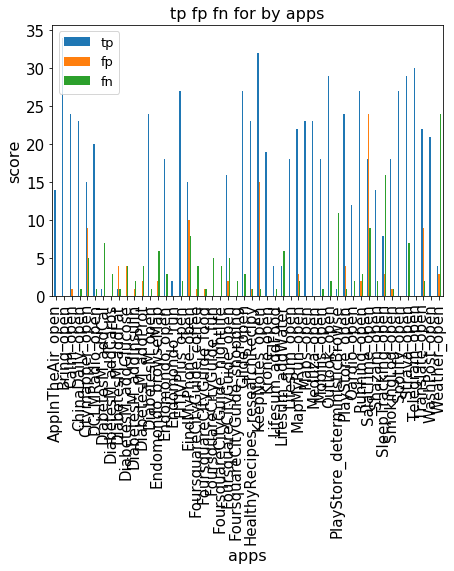

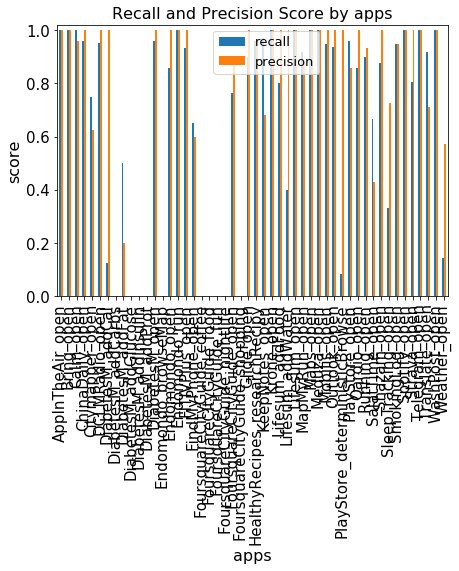

In [48]:
pr, tpfpfn = plot_prec_recall_by_slot(all_correct_pred_dict, all_wrong_pred_dict, all_missed_gt_dict, by="apps", savefig="towards")

In [49]:
def fbeta_score(x, precision="precision", recall="recall", beta=1.):
    p = float(x[precision])
    r = float(x[recall])
    if p == 0 or r == 0:
        return 0
    return (1 + beta**2) * (p * r)/((beta**2 * p) + r)

In [50]:
tpfpfn['count'] = tpfpfn['tp'] + tpfpfn['fn'] 

In [51]:
tpfpfn['prob'] = tpfpfn['count']/tpfpfn['count'].sum()

In [52]:
tpfpfn

,tp,fp,fn,count,prob
AppInTheAir_open,14.0,0.0,0.0,14.0,0.015642
Bring_open,34.0,0.0,0.0,34.0,0.037989
Calm_open,24.0,1.0,0.0,24.0,0.026816
ChinaDaily_open,23.0,0.0,1.0,24.0,0.026816
Citymapper_open,15.0,9.0,5.0,20.0,0.022346
DCLMRadio_open,20.0,0.0,1.0,21.0,0.023464
DiabetesM_addCal,1.0,0.0,7.0,8.0,0.008939
DiabetesM_addCarbs,0.0,0.0,3.0,3.0,0.003352
DiabetesM_addFat,1.0,4.0,1.0,2.0,0.002235
DiabetesM_addGlucose,0.0,4.0,4.0,4.0,0.004469


In [659]:
pr['f1'] = pr.apply(fbeta_score, axis=1)
fpr = pr.reindex(["f1", 'precision', 'recall'], axis=1) *100



In [660]:
fpr["count"] = tpfpfn["count"].astype(int)
s = fpr.sort_values(by=['f1', 'count'])

In [661]:
s = s.round(2).to_latex()
print(s.replace("\\_", " & "))

\begin{tabular}{lrrrr}
\toprule
{} &      f1 &  precision &  recall &  count \\
\midrule
FoursquareCityGuide & food      &    0.00 &        NaN &    0.00 &      1 \\
FoursquareCityGuide & shopping  &    0.00 &        NaN &    0.00 &      2 \\
DiabetesM & addGlucose          &    0.00 &       0.00 &    0.00 &      4 \\
DiabetesM & addProt             &    0.00 &        NaN &    0.00 &      4 \\
FoursquareCityGuide & nightlife &    0.00 &        NaN &    0.00 &      4 \\
FoursquareCityGuide & fun       &    0.00 &        NaN &    0.00 &      5 \\
Endomondo & browseMap           &    0.00 &       0.00 &    0.00 &      6 \\
Weather & open                  &   11.43 &      28.57 &    7.14 &     28 \\
PlayStore & deterministicBrowse &   15.38 &     100.00 &    8.33 &     12 \\
SleepTracking & open            &   15.38 &     100.00 &    8.33 &     24 \\
FoursquareCityGuide & coffee    &   33.33 &      50.00 &   25.00 &      4 \\
DiabetesM & addCal              &   36.36 &      66.67 &   25.00

In [666]:
tpfpfn

,tp,fp,fn,count,prob
AppInTheAir_open,14.0,0.0,0.0,14.0,0.015642
Bring_open,34.0,0.0,0.0,34.0,0.037989
Calm_open,24.0,1.0,0.0,24.0,0.026816
ChinaDaily_open,23.0,0.0,1.0,24.0,0.026816
Citymapper_open,18.0,10.0,2.0,20.0,0.022346
DCLMRadio_open,20.0,0.0,1.0,21.0,0.023464
DiabetesM_addCal,2.0,1.0,6.0,8.0,0.008939
DiabetesM_addCarbs,1.0,1.0,2.0,3.0,0.003352
DiabetesM_addFat,1.0,0.0,1.0,2.0,0.002235
DiabetesM_addGlucose,0.0,4.0,4.0,4.0,0.004469


In [53]:
#no apps
prec_recall

NameError: name 'prec_recall' is not defined

In [54]:
# apps

prec_recall

NameError: name 'prec_recall' is not defined

In [55]:
0.567901 - 0.397959

0.16994199999999998

In [664]:
0.938776 - 0.795918

0.14285800000000004

In [427]:
prec_recall.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &    recall &  precision \\\\\n\\midrule\nopen   &  0.844417 &   0.892573 \\\\\naction &  0.397959 &   0.795918 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [466]:
prec_recall

,recall,precision
open,0.847309,0.897878
action,0.567901,0.938776


In [395]:
prec_recall.dropna().sort_values(by="recall", ascending=False)

,recall,precision
Bring_open,0.852941,1.0
Spotify_open,0.703704,1.0
Qardio_open,0.642857,1.0
Calm_open,0.521739,1.0
ChinaDaily_open,0.500000,1.0
MapMyRun_open,0.500000,1.0
DiabetesM_open,0.480000,1.0
Mobilis_open,0.421053,1.0
SalatTime_open,0.370370,1.0
SmokingLog_open,0.368421,1.0


In [31]:
def plot_f1_prec_rec():
    linspace = np.arange(0, 1, 0.025)
    ps, rs, f1s = [], [], []
    for sensitivity in linspace:
        #all_correct_pred, all_wrong_pred, all_missed_gt = eval_all(predicted, content_ground_truth, METHOD="majority_voting", MATCH_METHOD='first', TOP_N=100)
        all_correct_pred_dict, all_wrong_pred_dict, all_missed_gt_dict = eval_all(predicted, 
                                                                                  content_ground_truth,
                                                                                  METHOD='threshold_majority_voting', # "majority_voting",
                                                                                  THRESHOLD=sensitivity,
                                                                                  MATCH_METHOD='first',
                                                                                  TARGET_APPS_ONLY=False,
                                                                                  TOP_N=1, OUTPUT_DICT=True,
                                                                                  SKIPPING_FORCE_STOP=True)
        p, r, f1 = plot_prec_recall_by_slot(all_correct_pred_dict, 
                                            all_wrong_pred_dict,
                                            all_missed_gt_dict,
                                            by="all", savefig=None)
        ps.append(p)
        rs.append(r)
        f1s.append(f1)
    plt.plot(linspace, rs, label="recall")
    plt.plot(linspace, ps, label="precision")
    plt.plot(linspace, f1s, label= "F1")
    plt.xlabel("Decision maker threshold", fontsize=14)
    plt.ylabel("score", fontsize=14)
    plt.title("Precision, Recall, F1 at different Threshold", fontsize = 16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(fontsize=14)
    plt.savefig("longrun_p_r_f1_threshold", dpi=80)
    max_ = np.argmax(f1s)
    print("maximum reached at ", linspace[max_])
    print(" precision: ", ps[max_])
    print(" recall: ", rs[max_])
    print(" recall: ", f1s[max_])
    return ps, rs, f1s
    
    
        
        

In [56]:
print(pd.DataFrame({"precision score":ps, "recall":rs, "F1":f1s, "threshold":linspace }).set_index("threshold").loc[[0.1, 0.8, 0.25]].to_latex())

NameError: name 'linspace' is not defined

maximum reached at  0.325
 precision:  0.9318181818181818
 recall:  0.7787709497206704
 recall:  0.8484479610468654


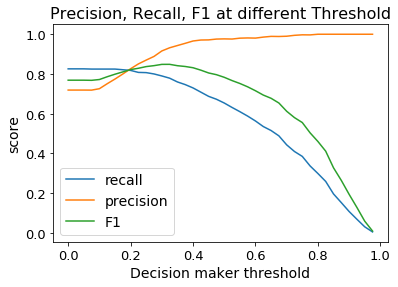

In [32]:
ps, rs, f1s = plot_f1_prec_rec()

maximum reached at  0.275
 precision:  0.8914919852034525
 recall:  0.8078212290502793
 recall:  0.8475967174677609


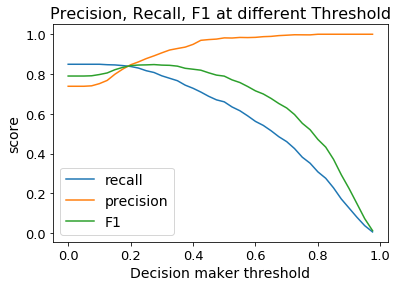

In [57]:
ps, rs, f1s = plot_f1_prec_rec()

In [29]:
ps[10]

0.8698795180722891

In [30]:
rs[10]

0.8067039106145252

In [380]:
f1s[10]

0.8386336866902238

In [379]:
linspace = np.arange(0, 1, 0.025)
linspace[10]

0.25

In [228]:
pr.apply(fbeta_score, axis=1)

0     0.708333
1     0.689655
2     0.692308
3     0.594595
4     0.625000
5     0.285714
6     0.526316
7     0.800000
8     0.754717
9     0.731707
10    0.773585
11    0.854369
12    0.711538
13    0.867257
14    0.781250
15    0.787879
16    0.803279
17    0.874074
18    0.779412
19    0.772727
20    0.784000
21    0.800000
22    0.778947
23    0.956522
dtype: float64

In [225]:
pr.columns

Index(['recall', 'precision'], dtype='object')

In [1050]:
def precision_recall_per_action(all_correct_pred_dict, all_wrong_pred_dict, all_missed_gt_dict, RETURN_COUNT=False, RETURN_PREC_REC=False):
    open_c, action_c, stop_c = 0, 0, 0
    open_w, action_w, stop_w = 0, 0, 0
    open_m, action_m, stop_m = 0, 0, 0
    
    # Flatten dict
    all_correct_pred = [preds[2][0] for cap in all_correct_pred_dict for preds in all_correct_pred_dict[cap]]
    all_wrong_pred = [preds[2][0] for cap in all_wrong_pred_dict for preds in all_wrong_pred_dict[cap]]
    all_missed_gt = [preds[2] for cap in all_missed_gt_dict for preds in all_missed_gt_dict[cap]]
    

    
    for c in all_correct_pred:
        if 'open' in c:
            open_c += 1
        elif 'force-stop' in c:
            stop_c += 1
        else:
            action_c += 1
            
    for w in all_wrong_pred:
        if 'open' in w:
            open_w += 1
        elif 'force-stop' in w:
            stop_w += 1
        else:
            action_w += 1

    for m in all_missed_gt:
        if 'open' in m:
            open_m += 1
        elif 'force-stop' in m:
            stop_m += 1
        else:
            action_m += 1
            
    precision_open = open_c / (open_w + open_c)
    recall_open = open_c / (open_c + open_m)
    
    precision_action = action_c / (action_w + action_c) if (stop_w + stop_c) else 1 # if no wrong prec = 1
    recall_action = action_c / (action_c + action_m) if (action_c + action_m) else 1 # if no truth label rec = 1

    precision_stop = stop_c / (stop_w + stop_c) if (stop_w + stop_c) else 1
    recall_stop = stop_c / (stop_c + stop_m) if (stop_c + stop_m) else 1

    print("precision open = {}\nrecall open = {}\n".format(precision_open, recall_open))
    print("precision stop = {}\nrecall stop = {}\n".format(precision_stop, recall_stop))
    print("precision action = {}\nrecall action = {}".format(precision_action, recall_action))

    if RETURN_COUNT:
        return ([open_c, action_c, stop_c], [open_w, action_w, stop_w], [open_m, action_m, stop_m])
    if RETURN_PREC_REC:
        return ([precision_open, recall_open], [precision_action, recall_action], [precision_stop,recall_stop])
        

precision open = 0.7545357524012807
recall open = 0.8926767676767676

precision stop = 0.2865853658536585
recall stop = 0.10633484162895927

precision action = 0.6190476190476191
recall action = 0.8227848101265823


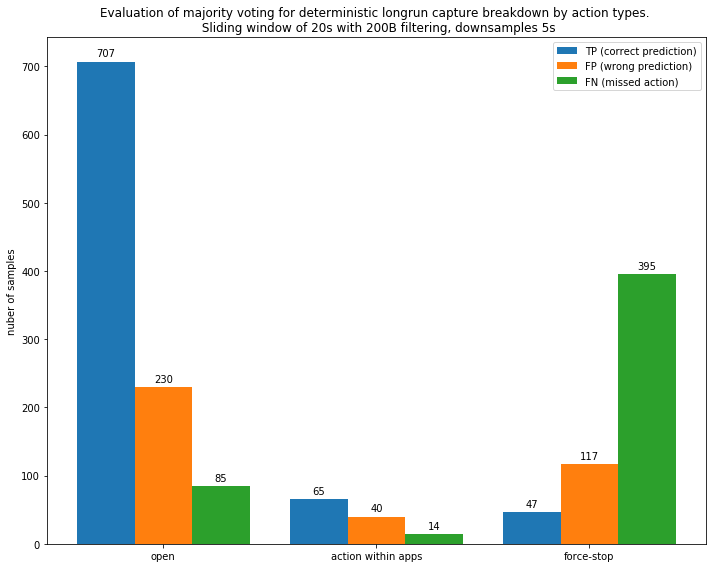

In [1051]:
labels = ['TP (correct prediction)', 'FP (wrong prediction)', 'FN (missed action)']
labels = ['open', 'action within apps', 'force-stop']

tp_vect = [open_c, action_c, stop_c]
fp_vect = [open_w, action_w, stop_w]
fn_vect = [open_m, action_m, stop_m]

tp_vect, fp_vect, fn_vect = precision_recall_per_action(all_correct_pred_dict, all_wrong_pred_dict, all_missed_gt_dict, RETURN_COUNT=True)

x = np.arange(len(labels))  # the label locations
width = 0.27  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, tp_vect, width, label='TP (correct prediction)')
rects2 = ax.bar(x , fp_vect, width, label='FP (wrong prediction)')
rects3 = ax.bar(x + width, fn_vect, width, label='FN (missed action)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('nuber of samples')
ax.set_title('Evaluation of majority voting for deterministic longrun capture breakdown by action types. \n Sliding window of 20s with 200B filtering, downsamples 5s')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig("./plots/Evaluation of majority voting for deterministic longrun capture breakdown by action types".replace(" ", "_"))
plt.show()

Precision recall breakdown by action types

In [967]:
precision_recall_per_action(all_correct_pred, all_wrong_pred, all_missed_gt)

 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 

 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 Beter use majority voting
 

IndexError: string index out of range

In [822]:
precision_recall_per_action(all_correct_pred, all_wrong_pred, all_missed_gt)

precision open = 0.7387198321091291
recall open = 0.8833124215809285

precision stop = 0.2937062937062937
recall stop = 0.09502262443438914

precision action = 0.36363636363636365
recall action = 0.40816326530612246


#### Breakdown by apps

In [664]:

wrong_preds = pd.Series([w[2] for w in all_wrong_pred])
correct_preds = pd.Series([c[2] for c in all_correct_pred])
missed_gts = pd.Series([m[2] for m in all_missed_gt])

In [665]:
wrong_count = wrong_preds.value_counts()
correct_count = correct_preds.value_counts()
missed_count = missed_gts.value_counts()

In [666]:
all_action_series = pd.Series([0] * len(all_trained_action) , list(all_trained_action))
correct_count = correct_count.add(all_action_series, fill_value=0).sort_values(ascending=False).astype(int)
wrong_count = wrong_count.add(all_action_series, fill_value=0).sort_values(ascending=False).astype(int)
missed_count = missed_count.add(all_action_series, fill_value=0).sort_values(ascending=False).astype(int)
action_not_in_dataset = correct_count[( correct_count + missed_count).fillna(0) == 0]

In [667]:
precisions = (correct_count /( correct_count + wrong_count)).fillna(0).sort_values(ascending=False)
recalls = (correct_count /( correct_count + missed_count)).fillna(0).sort_values(ascending=False)

precisions = precisions.drop(action_not_in_dataset.index)
recalls = recalls.drop(action_not_in_dataset.index)

In [668]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/AppInTheAir-1/", 
             "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/elapsed_time/open-13/", "data/huawei/force-stop-2/"]
# Discard:  'FitBreathe_open','FitWorkout_open','Fit_open'. Because of update does not send data anymore
DISCARDED_ACTION = [] # [ 'FitBreathe_open', 'FitWorkout_open', 'Fit_open', "Camera_force-stop"]

# Merge all force-stop in one class:
force_stop = ['AppInTheAir_force-stop', 'Bring_force-stop', 'ChinaDaily_force-stop', 'DCLMRadio_force-stop', 'Endomondo_force-stop', 'FindMyPhone_force-stop', 'FoursquareCityGuide_force-stop', 'KeepNotes_force-stop', 'Krone_force-stop', 'Lifesum_force-stop', 'Maps_force-stop', 'Meduza_force-stop', 'Running_force-stop', 'Spotify_force-stop', 'Strava_force-stop', 'Telegram_force-stop', 'Translate_force-stop', 'WashPost_force-stop']
TO_MERGE = [force_stop]
NAMES = ["AllApps_force-stop"]

y_true, y_pred = evaluate(DATA_PATH, TO_MERGE=TO_MERGE, MERGED_NAMES=NAMES,RETURN_PRED=True)



#### Per_action and longrun Comparaison in one DF

In [669]:
# in trained but not in longrun
action_not_in_longrun = correct_count[( correct_count + missed_count).fillna(0) == 0]

# in longrun but not in trained
action_not_in_trained = correct_count[( correct_count + wrong_count).fillna(0) == 0]

In [670]:
action_not_in_longrun

DiabetesM_addFat                0
FoursquareCityGuide_food        0
FoursquareCityGuide_shopping    0
dtype: int64

In [671]:
action_not_in_trained

DiabetesM_addCarbs               0
PlayStore_deterministicBrowse    0
dtype: int64

In [672]:
all_trained_action = np.array(list(all_trained_action))
precision , recall, f1_score, t = precision_recall_fscore_support(y_true, y_pred, labels = all_trained_action)


/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
model_precision = pd.Series(precision, all_trained_action)
model_recall = pd.Series(recall, all_trained_action)
model_precision = model_precision[precisions.index]
model_recall = model_recall[recalls.index]


In [43]:
total_evalution = pd.DataFrame([precisions, model_precision, recalls, model_recall], ["longrun_precision", "per_action_precision", "longrun_recall", "per_action_recall" ])
total_evaluation = total_evalution.transpose()

The $F_\beta$ score takes into account both precision and recall. $\beta$ is used to specciy which precision or recall we most care of if $\beta=1$, we call it the $F_1$ score and means both precision and recall should be weighted equally. 

The formula is the following

$$F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}.F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}.$$

In [44]:
def fbeta_score(x, precision, recall, beta=1.):
    p = float(x[precision])
    r = float(x[recall])
    if p == 0 or r == 0:
        return 0
    return (1 + beta**2) * (p * r)/((beta**2 * p) + r)

def diff_per_action_longrun(x):
    return x["per_action_f1_score"] - x["longrun_f1_score"]

In [45]:
# Compute the F1 score
total_evaluation["longrun_f1_score"] = total_evaluation.apply(lambda x: fbeta_score(x, precision="longrun_precision", recall ="longrun_recall"), axis=1)
total_evaluation["per_action_f1_score"] = total_evaluation.apply(lambda x: fbeta_score(x, precision="per_action_precision", recall ="per_action_recall"), axis=1)
total_evaluation["diff_f1"] = total_evaluation.apply(lambda x: diff_per_action_longrun(x), axis=1)
diff_F1 = total_evaluation.sort_values("diff_f1", ascending = True)["diff_f1"]

In [46]:
# The closer to 0, t
diff = diff_F1.sum()/diff_F1.count()

print("Loss : {}\n".format(diff))
print("The loss represents the loss between longrun and per_action averaged by action in therms of F1 score.")
print("the closer to 0 the better is the second part of the attack since closer to the first part")






Loss : -0.38361568562682186

The loss represents the loss between longrun and per_action averaged by action in therms of F1 score.
the closer to 0 the better is the second part of the attack since closer to the first part


In [47]:
print("Less than 5% loss actions:\n")
print(diff_F1[diff_F1 < 0.05])

print("\nMore than 90% loss action:\n")
print(diff_F1[diff_F1 > 0.70])

Less than 5% loss actions:

Telegram_open              -1.000000
Bring_open                 -1.000000
Spotify_open               -1.000000
Maps_open                  -1.000000
Meduza_open                -1.000000
DiabetesM_open             -0.979592
DCLMRadio_open             -0.976744
Krone_open                 -0.974359
Translate_open             -0.958333
Calm_open                  -0.958333
Shazam_open                -0.933333
FITIVPlus_open             -0.931034
ChinaDaily_open            -0.920000
Glide_open                 -0.912281
Endomondo_open             -0.904762
Strava_open                -0.882353
PlayStore_open             -0.877193
WashPost_open              -0.869565
Lifesum_open               -0.857143
MapMyRun_open              -0.821429
SmokingLog_open            -0.800000
Mobilis_open               -0.782609
Qardio_open                -0.764706
Outlook_open               -0.759494
Running_open               -0.753247
FindMyPhone_open           -0.666667
Foursquare

A loss of 0 signify that we are as good as the per_capture action. a 1oss of 1 sgnify that in the per_action capture we have the maximum score but in the longrun we have the minimum score. 

### Top N accuracy
[Table of Content](#tc)

In [347]:
precisions = []
recalls = []
ns = []


for n in range(1,71):
    all_wrong_pred = []
    all_correct_pred = []
    all_missed_gt = []
    for capture in captures:
        if capture == "longrun_deterministic_20-04-03_04-23-24":
            continue
        (correct_pred, wrong_pred, missed_gt) = compute_eval_metric(predicted[capture] , 
                                                                    content_ground_truth[capture],
                                                                    METHOD='top_n_majority_voting', 
                                                                    TOP_N=n, print_details=False)
        all_wrong_pred += wrong_pred
        all_correct_pred += correct_pred
        all_missed_gt += missed_gt


        tp, fp, fn = len(correct_pred), len(wrong_pred), len(missed_gt)

        precision = 1 if tp + fp == 0 else tp / (tp + fp)
        recall = 1 if tp + fn == 0 else tp / (tp + fn)

    tp, fp, fn = len(all_correct_pred), len(all_wrong_pred), len(all_missed_gt)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)
    ns.append(n)

In [346]:
def plot_precision_recall(steps, precisions, recalls, title, x_label, y_label):
    fig, ax = plt.subplots()
    dpi = 200
    fname = title.replace(" ", "_")
    y_lim = None
    ax.plot(steps, precisions, '-r', label='precision')
    ax.plot(steps, recalls, '-b', label='recall')
    plt.title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if y_lim is not None:
        plt.ylim(y_lim[0], y_lim[1])
    leg = ax.legend()
    plt.savefig("./plots/"+fname, dpi=dpi)

    

title = "Precision and Recall for the longrun capture by taking the top-n prediciton"
x_label = "top-n predictions"
y_label = "precision, recall"

plot_precision_recall(ns, precisions, recalls, title, x_label, y_label)

NameError: name 'ns' is not defined

Remarks: We can isolate pred that does not match any 

## Towards Realisitc Captures

### Be carefull with Fit Playstore Browse Map



1. **equilibrate actions** 

If an app counts 3 actions: a1, a2, a3 and another app countains only 1 action b1

we should have P(a1 or a2 or a3) = P(b1) = 0.5

In [ ]:
# First, equilibrate actions. If an app counts 3 actions: a1, a2, a3 and another app countains only 1 action b1
# we should have P(a1 or a2 or a3) = P(b1) = 0.5
from collections import Counter
action_per_apps = Counter()
kept_actions = []
for action in all_trained_action:
    app, act = action.split("_")
    # skip force stop because anyway open trigers stop
    if act == "force-stop":
        continue 
    action_per_apps[app] += 1
    
    kept_actions.append(action)
apps_prob_vect = dict(action_per_apps)
total_app = len(c)
for app in apps_prob_vect:
    apps_prob_vect[app] = 1/total_app
apps_prob_vect

In [ ]:
precisions = []
recalls = []
ns = []
for n in range(1,71):
    all_wrong_pred = []
    all_correct_pred = []
    all_missed_gt = []
    for capture in captures:
        if capture == "longrun_deterministic_20-04-03_04-23-24":
            continue
        (correct_pred, wrong_pred, missed_gt) = compute_eval_metric(predicted[capture] , content_ground_truth[capture], method='top_n_majority_voting', TOP_N=n, print_details=False)
        all_wrong_pred += wrong_pred
        all_correct_pred += correct_pred
        all_missed_gt += missed_gt


        tp, fp, fn = len(correct_pred), len(wrong_pred), len(missed_gt)

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

    tp, fp, fn = len(all_correct_pred), len(all_wrong_pred), len(all_missed_gt)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)
    ns.append(n)

2. **Hight probability of popular application**

Application from this category should occur with a higher probability since they are more popular to trigger according to the study: 

"*Characterizing Smartwatch Usage In The Wild*" : Table 6 lists the most popular used apps in our dataset; they include `messengers`, `email clients`, `maps`, `activity trackers`, and `note taking` software.

<img src="./Results/popular_application.png">

In [ ]:
fig, ax = plt.subplots()
title = "Precision and Recall for the longrun capture by taking the top-n prediciton"
x_label = "top-n predictions"
y_label = "precision, recall"
dpi = 200
fname = title.replace(" ", "_")
y_lim = None
ax.plot(ns, precisions, '-r', label='precision')
ax.plot(ns, recalls, '-b', label='recall')
plt.title(title)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
if y_lim is not None:
    plt.ylim(y_lim[0], y_lim[1])
leg = ax.legend()
plt.savefig("./plots/"+fname, dpi=dpi)

In [962]:
apps = []
for app in apps_prob_vect:
    apps.append(app)

print("Application list:\n")
print("'" + "', '".join(apps) + "'")

Application list:

'Translate', 'DiabetesM', 'FitWorkout', 'Weather', 'PlayStore', 'Glide', 'Endomondo', 'FoursquareCityGuide', 'KeepNotes', 'Lifesum', 'SmokingLog', 'WashPost', 'MapMyRun', 'ChinaDaily', 'Running', 'Shazam', 'Fit', 'FITIVPlus', 'FitBreathe', 'Mobilis', 'SleepTracking', 'Citymapper', 'Bring', 'Krone', 'Outlook', 'FindMyPhone', 'Maps', 'DCLMRadio', 'Meduza', 'SalatTime', 'Telegram', 'HealthyRecipes', 'Spotify', 'Calm', 'Strava'


In [963]:
# Categories
messengers = ['Telegram', 'Glide']
emails = ['Outlook']
maps = ['Maps', 'Citymapper', 'FoursquareCityGuide']
fitness = ['FitWorkout', 'Fit', 'FITIVPlus', 'Endomondo', 'Strava', 'Running']
note_taking = ['Bring', 'KeepNotes']
health = ['Lifesum', 'SmokingLog', 'HealthyRecipes','DiabetesM']
banking = ['Mobilis']
media = ['ChinaDaily', 'Krone', 'WashPost', 'Meduza']
religious = ['DCLMRadio', 'SalatTime']
other = ['Translate', 'Weather', 'PlayStore', 'Shazam', 'FitBreathe', 'SleepTracking', 'FindMyPhone', 'Spotify', 'Calm']

In [964]:
popular = messengers + emails + fitness + note_taking

In [551]:
train_test_split([0, 1,2,3,4,5, 6, 7, 8, 9], 
                 [0, 0,0,0,0,1, 1, 1, 1, 1], 
                 stratify=[0, 0,0,0,0,1, 1, 1, 1, 1],
                 train_size=2)

[[1, 9], [6, 4, 7, 3, 2, 8, 5, 0], [0, 1], [1, 0, 1, 0, 0, 1, 1, 0]]

In [ ]:
npa

We want to derive the porbability vector of picking each apps. (The action within each apps will be equiprobable)

Let:

$p_{norm}$ be the probability of picking an action in the normal

$p_{pop}$ be the probability of picking an action in the popular set

$f$ be the factor at which the probability of picking an action in the popular is more likely to happen than the normal set

$N=|\{p_{norm}\}|$ be the cardinality of the action in the normal

$L=|\{p_{pop}\}|$ be the cardinality of action in the popular set



Then we have:

1. $\sum_{i}{p_i}=1$
2. $p_{pop} = f*p_{norm}$



With 1. and 2. : 

$$ L*f*p_{pop} + (N-L)*p_{norm} = 1 $$

Thus:

$p_{pop}=\frac{f}{N+L*(f-1)}$

$p_{norm}=\frac{1}{N+L*(f-1)}$



In [ ]:
f = 1.5  # multiplication factor. f more time to occur if in popular 
L = len(popular)
N = len(apps)

p_popular = f/(N + L * (f - 1)) 
p_normal = 1/(N + L * (f - 1)) 

# recompute probability vector
for app in apps_prob_vect:
    if app in popular: 
        apps_prob_vect[app] = p_popular
    else:
        apps_prob_vect[app] = p_normal

if sum(apps_prob_vect.values()) != 1.0:
    print("Error! Not a distribution probability. Please check the popular set")

cumul prob = 0


In [974]:
cumul = 0 
for app in apps_prob_vect:
    cumul += apps_prob_vect[app]
    apps_prob_vect[app] = cumul

In [975]:
apps_prob_vect

{'Translate': 0.024691358024691357,
 'DiabetesM': 0.04938271604938271,
 'FitWorkout': 0.08641975308641975,
 'Weather': 0.1111111111111111,
 'PlayStore': 0.13580246913580246,
 'Glide': 0.1728395061728395,
 'Endomondo': 0.20987654320987653,
 'FoursquareCityGuide': 0.2345679012345679,
 'KeepNotes': 0.2716049382716049,
 'Lifesum': 0.2962962962962963,
 'SmokingLog': 0.32098765432098764,
 'WashPost': 0.345679012345679,
 'MapMyRun': 0.37037037037037035,
 'ChinaDaily': 0.3950617283950617,
 'Running': 0.43209876543209874,
 'Shazam': 0.4567901234567901,
 'Fit': 0.49382716049382713,
 'FITIVPlus': 0.5308641975308641,
 'FitBreathe': 0.5555555555555555,
 'Mobilis': 0.5802469135802468,
 'SleepTracking': 0.6049382716049382,
 'Citymapper': 0.6296296296296295,
 'Bring': 0.6666666666666665,
 'Krone': 0.6913580246913579,
 'Outlook': 0.728395061728395,
 'FindMyPhone': 0.7530864197530863,
 'Maps': 0.7777777777777777,
 'DCLMRadio': 0.802469135802469,
 'Meduza': 0.8271604938271604,
 'SalatTime': 0.85185185185

In [1008]:
def pick_app_from_prob_vect(apps_prob_vect):
    r = random.random()
    for app in apps_prob_vect:
        if r < apps_prob_vect[app]:
            #print("r={}, app = {}".format(r, app))
            return app
    return app

3. **Time interval performed actions**

Should follow the same trend as the action utilisation 


<img src="./Results/user_temporal_usage.png">

<img src="./Results/user_interation_level.png" width="700">

Text(0, 0.5, 'Normalized User Interaction')

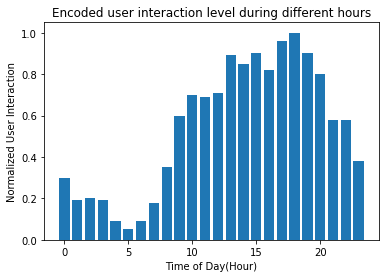

In [295]:
import time
t = time.time()
norm_user_interact_slot_10 = [0.3, 0.2, 0.2, 0.19, 0.1, 0.05, 0.1, 0.21, 0.42, 0.5, 0.6, 0.68, 0.7, 0.835, 0.84, 0.9, 0.85, 1, 0.96, 0.85, 0.8, 0.6, 0.61, 0.37]
norm_user_interact_slot_30 = [0.3, 0.19, 0.2, 0.19, 0.09, 0.05, 0.09, 0.18, 0.35, 0.6, 0.7, 0.69, 0.71, 0.89, 0.85, 0.9, 0.82, 0.96, 1, 0.9, 0.8, 0.58, 0.58, 0.38]
plt.bar(x = np.arange(24), height=norm_user_interact_slot_30)
plt.title("Encoded user interaction level during different hours")
plt.xlabel("Time of Day(Hour)")
plt.ylabel("Normalized User Interaction")

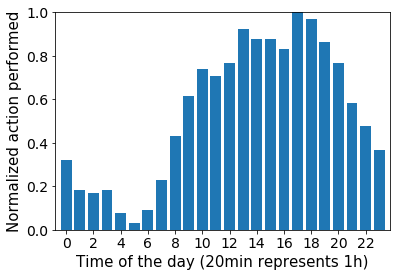

In [331]:
PATH = "./data/huawei/longrun/user-interaction-pattern-{}/"
GROUND_TRUTH_PATH = PATH + "ground-truth/"
slots_action_count = []

caps = [1,2,3]
for i in caps:
    gt_path_content = sorted(glob.glob(GROUND_TRUTH_PATH.format(i) + '*.log', recursive=True))
    gt_content = read_longrun_log_files(gt_path_content)

    
    for c in gt_content:
        count = 0
        for a in gt_content[c]:
            if "open" in a[1]:

                count += 1
        slots_action_count.append(count)

slots_action_count = np.array(slots_action_count) 
slots_action_count = np.mean(slots_action_count.reshape((3, -1)), axis=0) 
slots_action_count = slots_action_count/np.max(slots_action_count)

fig, ax1 = plt.subplots()
plt.bar(x = np.arange(24), height=slots_action_count)
plt.xlabel("Time of the day (20min represents 1h)", fontsize=15)
plt.ylabel("Normalized action performed", fontsize=15)
plt.ylim([0,1])
plt.xlim([-0.8,23.8])
plt.xticks(range(0,24,2), fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("reproduced_user_interaction_level",bbox_inches='tight', dpi=120)

TODO:

1. Consider cutting only if not received any packet with length l > n after t time for different n and t
2. Make multiple window size concurentlly 
2. Train classifer for wrong classified allows to increase accuracy (But decrease Recall)
    1. On proba output: Correct Pred -> 1 / Wrong Pred -> 0 (Better I guess)
    2. On features Vec: Use NoApp_NoAction as another class 
    
3. Try to identify closing apps all_together and make the classifier discard them


TOCAREOF:
1. deterministicBrowse as a greater delay


## Model improvement

### Exploring meta parameters 

In [161]:
ls data/huawei/longrun/

deterministic-15min-1/      uniform-20min-1/
deterministic-15min-2/      uniform-20min-2/
deterministic-20min-1/      uniform-20min-3/
deterministic-30min-1/      user-interaction-pattern-1/
longrun-background-noise/   user-interaction-pattern-2/
uniform-15min-1/            user-interaction-pattern-3/
uniform-1h/


In [786]:
# imports
DATA_PATH = ["./data/huawei/longrun/deterministic-20min-1/", "./data/huawei/longrun/uniform-20min-1/"]
captures, content_ground_truth = import_longrun(DATA_PATH, ALL_TRAINED_ACTION=all_trained_action, MERGED_FORCE_STOP=force_stop)

Exporting data in :./data/huawei/longrun/deterministic-20min-1/
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed
PlayStore_deterministicBrowse bound changed


TypeError: new_packet() takes 0 positional arguments but 1 was given

In [176]:
for i in np.arange(0, 5.5, 0.5):
    print(i, end=', ')

0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 

In [891]:
'longrun_user-interact-pattern_20-04-09_14-11-37_slot-0'.split("_")[2]

'20-04-09'

In [606]:
# loop here
recalls_open, precisions_open = [], []
recalls_action, precisions_action = [], []
recalls_stop, precisions_stop = [], []


steps = range(100,650, 50)

for i in steps:
    print(i)
    
    predicted = predict_all(captures, INTER_TIMER_EVENT_CUTOFF=10, WINDOW_SIZE=3, WINDOW_MINIMAL_PAYLOAD=i)
    all_correct_pred, all_wrong_pred, all_missed_gt = eval_all(predicted, content_ground_truth, DPRINT=False)
    open_, action, stop = precision_recall_per_action(all_correct_pred, all_wrong_pred, all_missed_gt, RETURN_PREC_REC=True)
    precisions_open.append(open_[0])
    recalls_open.append(open_[1])
    precisions_action.append(action[0])
    recalls_action.append(action[1])
    precisions_stop.append(stop[0])    
    recalls_stop.append(stop[1])


100
precision open = 0.7831184056271981
recall open = 0.8381430363864492

precision stop = 0.22023809523809523
recall stop = 0.083710407239819

precision action = 0.1971153846153846
recall action = 0.41836734693877553
150
precision open = 0.7920193470374849
recall open = 0.821831869510665

precision stop = 0.2713178294573643
recall stop = 0.07918552036199095

precision action = 0.18181818181818182
recall action = 0.40816326530612246
200
precision open = 0.7946210268948656
recall open = 0.8155583437892095

precision stop = 0.2905982905982906
recall stop = 0.07692307692307693

precision action = 0.18518518518518517
recall action = 0.40816326530612246
250
precision open = 0.7980049875311721
recall open = 0.8030112923462986

precision stop = 0.30275229357798167
recall stop = 0.0746606334841629

precision action = 0.18807339449541285
recall action = 0.41836734693877553
300
precision open = 0.8128205128205128
recall open = 0.795483061480552

precision stop = 0.27184466019417475
recall stop =

In [593]:
precisions_open

[0.7925925925925926,
 0.7946210268948656,
 0.777122641509434,
 0.7621247113163973,
 0.7571592210767468,
 0.7480314960629921,
 0.7477678571428571,
 0.744988864142539,
 0.7414364640883978,
 0.7339149400218102,
 0.7346278317152104,
 0.7346938775510204,
 0.7376873661670236,
 0.7356076759061834,
 0.7353878852284803,
 0.7356687898089171,
 0.7360084477296727,
 0.7350157728706624,
 0.7319371727748691,
 0.7309697601668405,
 0.73125,
 0.7315296566077003,
 0.7313278008298755,
 0.7305699481865285,
 0.7308488612836439,
 0.7308488612836439,
 0.7298136645962733,
 0.7300930713547052,
 0.7285861713106295]

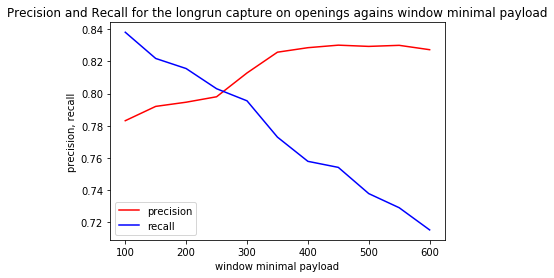

In [607]:
title = "Precision and Recall for the longrun capture on openings agains window minimal payload"
x_label = "window minimal payload"
y_label = "precision, recall"

plot_precision_recall(steps, precisions_open, recalls_open, title, x_label, y_label)

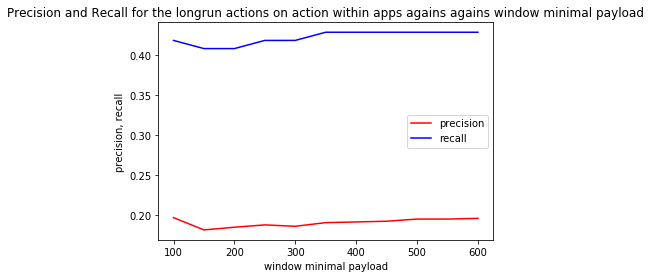

In [608]:
title = "Precision and Recall for the longrun actions on action within apps agains agains window minimal payload"
x_label = "window minimal payload"
y_label = "precision, recall"

plot_precision_recall(steps, precisions_action, recalls_action, title, x_label, y_label)

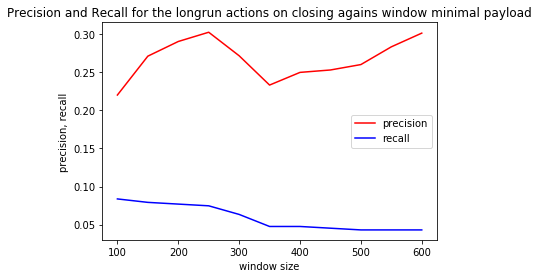

In [609]:
title = "Precision and Recall for the longrun actions on closing agains window minimal payload"
x_label = "window size"
y_label = "precision, recall"

plot_precision_recall(steps, precisions_stop, recalls_stop, title, x_label, y_label)

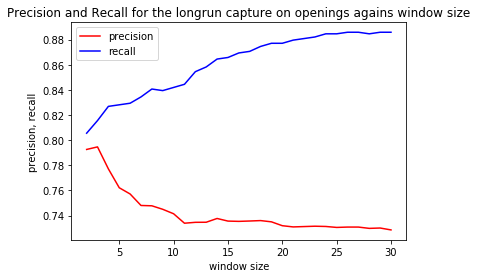

In [599]:
title = "Precision and Recall for the longrun capture on openings agains window minimal payload"
x_label = "window size"
y_label = "precision, recall"
steps = range(2, 31)

plot_precision_recall(steps, precisions_open, recalls_open, title, x_label, y_label)

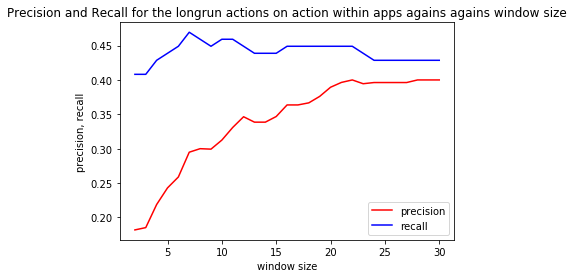

In [600]:
title = "Precision and Recall for the longrun actions on action within apps agains agains window size"
x_label = "window size"
y_label = "precision, recall"

plot_precision_recall(steps, precisions_action, recalls_action, title, x_label, y_label)

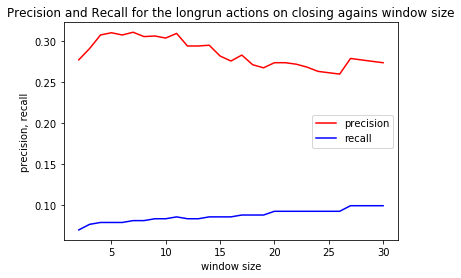

In [601]:
title = "Precision and Recall for the longrun actions on closing agains window size"
x_label = "window size"
y_label = "precision, recall"

plot_precision_recall(steps, precisions_stop, recalls_stop, title, x_label, y_label)

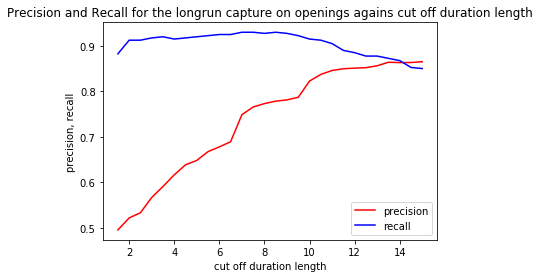

In [189]:
title = "Precision and Recall for the longrun capture on openings agains cut off duration length"
x_label = "cut off duration length"
y_label = "precision, recall"
steps = np.arange(1.5, 15.5, 0.5)

plot_precision_recall(steps, precisions_open, recalls_open, title, x_label, y_label)

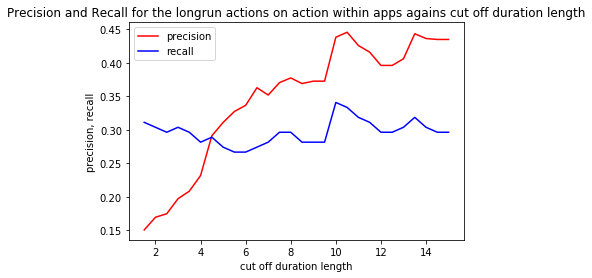

In [190]:
title = "Precision and Recall for the longrun actions on action within apps agains cut off duration length"
x_label = "cut off duration length"
y_label = "precision, recall"

plot_precision_recall(steps, precisions_action, recalls_action, title, x_label, y_label)

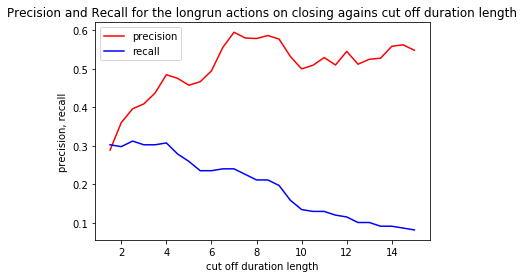

In [191]:
title = "Precision and Recall for the longrun actions on closing agains cut off duration length"
x_label = "cut off duration length"
y_label = "precision, recall"

plot_precision_recall(steps, precisions_stop, recalls_stop, title, x_label, y_label)

### Training The classifier with output probabilities

#### Create dataset

In [667]:
act = "Weather_open"
for c in content_ground_truth:
    for gt in content_ground_truth[c]:
        if gt[2] == act:
            print(c)
            print(gt)
            print()

print("\n##########Pred:\n\n")
for c in all_wrong_pred_dict:
    for preds in all_wrong_pred_dict[c]:
        if preds[2][0] == act:
            print(c)
            print(preds)
            print()
        

longrun_user-interact-pattern_20-04-09_14-11-37_slot-0
(1154.5, 1172.3, 'Weather_open')

longrun_user-interact-pattern_20-04-09_16-58-08_slot-8
(562.4, 580.2, 'Weather_open')

longrun_user-interact-pattern_20-04-09_17-18-53_slot-9
(599.4, 617.2, 'Weather_open')

longrun_user-interact-pattern_20-04-09_18-00-51_slot-11
(1024.5, 1042.3, 'Weather_open')

longrun_user-interact-pattern_20-04-09_18-42-46_slot-13
(546.4999999999999, 564.3, 'Weather_open')

longrun_user-interact-pattern_20-04-09_19-03-44_slot-14
(1046.6, 1064.4, 'Weather_open')

longrun_user-interact-pattern_20-04-09_20-27-02_slot-18
(862.5999999999999, 880.4, 'Weather_open')

longrun_user-interact-pattern_20-04-09_20-47-49_slot-19
(630.5999999999999, 648.4, 'Weather_open')

longrun_user-interact-pattern_20-04-09_21-50-08_slot-22
(55.899999999999935, 73.7, 'Weather_open')

longrun_user-interact-pattern_20-04-11_17-13-16_slot-9
(507.0999999999999, 524.9, 'Weather_open')

longrun_user-interact-pattern_20-04-11_18-16-15_slot-12
(3

In [621]:

# Import longrun captures and ground-truth
DATA_PATH = ["./data/huawei/longrun/uniform-20min-3/"]
#captures, content_ground_truth = import_longrun(DATA_PATH, DPRINT=False, ALL_TRAINED_ACTION=all_trained_action, MERGED_FORCE_STOP=force_stop)
predicted = predict_all(captures, DPRINT=True, WINDOW_SIZE=10)

longrun_user-interact-pattern_20-04-09_14-11-37_slot-0


ValueError: Number of features of the model must match the input. Model n_features is 488 and input n_features is 1002 

In [517]:
# Etract all wrong predictions wrt. timing
# correct_should_be_all, wrong_pred , missed_sould_be_none = eval_all(predicted, content_ground_truth, 'top_n_majority_voting', TOP_N=1000, OUTPUT_DICT=True)
# all correct prediction
correct_pred, wrong_pred, missed_pred = eval_all(predicted, content_ground_truth, 'majority_voting', OUTPUT_DICT=True, DPRINT=False)

In [501]:
missed_pred['longrun_uniform_20-04-20_11-50-25']

[(97.69999999999993, 115.5, 'AllApps_force-stop'),
 (127.99999999999993, 145.8, 'DiabetesM_addGlucose'),
 (212.89999999999992, 230.7, 'AllApps_force-stop'),
 (248.19999999999993, 266.0, 'Weather_open'),
 (771.8, 789.6, 'DiabetesM_addGlucose'),
 (864.6999999999999, 882.5, 'AllApps_force-stop'),
 (1125.5, 1143.3, 'AllApps_force-stop')]

In [518]:
missed_pred['longrun_uniform_20-04-20_11-50-25']

[(97.69999999999993, 115.5, 'AllApps_force-stop'),
 (127.99999999999993, 145.8, 'DiabetesM_addGlucose'),
 (212.89999999999992, 230.7, 'AllApps_force-stop'),
 (248.19999999999993, 266.0, 'Weather_open'),
 (771.8, 789.6, 'DiabetesM_addGlucose'),
 (864.6999999999999, 882.5, 'AllApps_force-stop'),
 (1125.5, 1143.3, 'AllApps_force-stop'),
 (1149.1999999999998, 1167.0, 'SleepTracking_open')]

In [494]:
missed_pred['longrun_uniform_20-04-20_11-50-25']

[(97.69999999999993, 115.5, 'AllApps_force-stop'),
 (127.99999999999993, 145.8, 'DiabetesM_addGlucose'),
 (212.89999999999992, 230.7, 'AllApps_force-stop'),
 (248.19999999999993, 266.0, 'Weather_open'),
 (771.8, 789.6, 'DiabetesM_addGlucose'),
 (864.6999999999999, 882.5, 'AllApps_force-stop'),
 (1125.5, 1143.3, 'AllApps_force-stop')]

In [519]:
missed_pred['longrun_uniform_20-04-20_11-50-25']

[(97.69999999999993, 115.5, 'AllApps_force-stop'),
 (127.99999999999993, 145.8, 'DiabetesM_addGlucose'),
 (212.89999999999992, 230.7, 'AllApps_force-stop'),
 (248.19999999999993, 266.0, 'Weather_open'),
 (771.8, 789.6, 'DiabetesM_addGlucose'),
 (864.6999999999999, 882.5, 'AllApps_force-stop'),
 (1125.5, 1143.3, 'AllApps_force-stop'),
 (1149.1999999999998, 1167.0, 'SleepTracking_open')]

In [502]:
correct_pred['longrun_uniform_20-04-20_11-50-25']

#print(len(correct_pred['longrun_uniform_20-04-20_11-50-25']))

[(8.665500125, 26.384206375, 'Citymapper_open'),
 (64.9153835, 76.093484875, 'Translate_open'),
 (78.767242125, 121.630305875, 'DiabetesM_open'),
 (155.410926375, 197.481567625, 'Endomondo_open'),
 (334.16696125, 334.53571225, 'SmokingLog_open'),
 (395.664947875, 395.806820875, 'Qardio_open'),
 (460.9173195, 461.554194125, 'Glide_open'),
 (499.164802375, 517.303501625, 'Outlook_open'),
 (566.66401025, 580.2452405, 'SalatTime_open'),
 (607.9145615, 652.10884, 'HealthyRecipes_researchRecipy'),
 (691.914382125, 708.619362125, 'Outlook_open'),
 (750.413645125, 764.426736375, 'DiabetesM_open'),
 (815.663564375, 841.6685285, 'Endomondo_open'),
 (846.129166625, 856.8254425, 'Endomondo_browseMap'),
 (879.143598125, 890.050471875, 'SleepTracking_open'),
 (913.951086125, 950.809128, 'SmokingLog_open'),
 (988.914063625, 1000.180934125, 'FITIVPlus_open'),
 (1024.914028875, 1042.306494625, 'SmokingLog_open'),
 (1091.43083125, 1126.89275675, 'Maps_open'),
 (1132.914019875, 1152.5952275, 'SleepTracki

In [520]:
correct_pred['longrun_uniform_20-04-20_11-50-25']

#print(len(correct_pred['longrun_uniform_20-04-20_11-50-25']))

[(19.165470625, 26.384206375, 'Citymapper_open'),
 (75.414733125, 76.093484875, 'Translate_open'),
 (114.415321625, 121.630305875, 'DiabetesM_open'),
 (157.67718125, 197.481567625, 'Endomondo_open'),
 (334.16696125, 334.53571225, 'SmokingLog_open'),
 (395.664947875, 395.806820875, 'Qardio_open'),
 (460.9173195, 461.554194125, 'Glide_open'),
 (510.414771625, 517.303501625, 'Outlook_open'),
 (566.66401025, 580.2452405, 'SalatTime_open'),
 (617.663908125, 652.10884, 'HealthyRecipes_researchRecipy'),
 (701.664356375, 708.619362125, 'Outlook_open'),
 (760.164243875, 764.426736375, 'DiabetesM_open'),
 (826.16416125, 841.6685285, 'Endomondo_open'),
 (846.129166625, 856.8254425, 'Endomondo_browseMap'),
 (880.740478875, 890.050471875, 'SleepTracking_open'),
 (914.43608725, 950.809128, 'SmokingLog_open'),
 (988.914063625, 1000.180934125, 'FITIVPlus_open'),
 (1039.163999, 1042.306494625, 'SmokingLog_open'),
 (1093.163953125, 1126.89275675, 'Maps_open')]

In [504]:
wrong_pred['longrun_uniform_20-04-20_11-50-25']
#print(len(wrong_pred['longrun_uniform_20-04-20_11-50-25']))

[(124.306561125, 142.337779125, 'SalatTime_open'),
 (143.69903225, 152.859670625, 'DiabetesM_addCal'),
 (199.7909465, 214.06910725, 'Endomondo_browseMap'),
 (214.209731, 251.41841125, 'Translate_open'),
 (466.381704375, 471.2567, 'KeepNotes_open'),
 (483.417318375, 492.33917225, 'AllApps_force-stop'),
 (769.45549625, 785.866705, 'Outlook_open'),
 (789.49421325, 795.967342125, 'Telegram_open'),
 (861.794829125, 865.55796475, 'Endomondo_browseMap'),
 (869.229224625, 878.13609575, 'Endomondo_open'),
 (896.663606625, 909.45857525, 'Citymapper_open'),
 (1068.413960625, 1086.462694125, 'AllApps_force-stop'),
 (1155.89711025, 1208.663932375, 'Citymapper_open')]

In [521]:
wrong_pred['longrun_uniform_20-04-20_11-50-25']
#print(len(wrong_pred['longrun_uniform_20-04-20_11-50-25']))

[(134.667171125, 142.337779125, 'SalatTime_open'),
 (145.93903725, 152.859670625, 'DiabetesM_addGlucose'),
 (199.7909465, 214.06910725, 'Endomondo_browseMap'),
 (250.91716025, 251.41841125, 'Endomondo_browseMap'),
 (466.381704375, 471.2567, 'KeepNotes_open'),
 (777.4136005, 785.866705, 'Outlook_open'),
 (789.49421325, 795.967342125, 'Telegram_open'),
 (861.794829125, 865.55796475, 'Endomondo_browseMap'),
 (869.229224625, 878.13609575, 'Endomondo_open'),
 (906.4167095, 909.45857525, 'Citymapper_open'),
 (1078.163312375, 1086.462694125, 'AllApps_force-stop'),
 (1152.417100875, 1152.5952275, 'Endomondo_browseMap'),
 (1171.913335125, 1208.663932375, 'Citymapper_open')]

In [505]:
content_ground_truth['longrun_uniform_20-04-20_11-50-25']
#print(len(content_ground_truth['longrun_uniform_20-04-20_11-50-25']))

[(21.699999999999932, 39.5, 'Citymapper_open'),
 (70.29999999999993, 88.1, 'Translate_open'),
 (97.69999999999993, 115.5, 'AllApps_force-stop'),
 (118.99999999999993, 136.8, 'DiabetesM_open'),
 (127.99999999999993, 145.8, 'DiabetesM_addGlucose'),
 (185.59999999999994, 203.4, 'Endomondo_open'),
 (212.89999999999992, 230.7, 'AllApps_force-stop'),
 (248.19999999999993, 266.0, 'Weather_open'),
 (329.3999999999999, 347.2, 'SmokingLog_open'),
 (391.49999999999994, 409.3, 'Qardio_open'),
 (454.0999999999999, 471.9, 'Glide_open'),
 (513.5999999999999, 531.4, 'Outlook_open'),
 (572.8, 590.6, 'SalatTime_open'),
 (635.9, 653.7, 'HealthyRecipes_researchRecipy'),
 (705.0999999999999, 722.9, 'Outlook_open'),
 (762.8, 780.6, 'DiabetesM_open'),
 (771.8, 789.6, 'DiabetesM_addGlucose'),
 (829.4, 847.2, 'Endomondo_open'),
 (838.4, 856.2, 'Endomondo_browseMap'),
 (864.6999999999999, 882.5, 'AllApps_force-stop'),
 (886.4, 904.2, 'SleepTracking_open'),
 (946.4999999999999, 964.3, 'SmokingLog_open'),
 (991.4

In [132]:
capture = 'longrun_uniform_20-04-20_11-50-25'

for capture in wrong_pred:
    for wrong in wrong_pred[capture]:
        overlaped = False
        for gt in content_ground_truth[capture]:

            if overlaps((wrong[0],wrong[1]), (gt[0],gt[1])):
    #            print((wrong[0],wrong[1]), (gt[0],gt[1]))
                #print("wrong: ",wrong)
                #print("   gt: ",gt)
                #print()
                overlapped = True
                break
        if not overlapped:
            print("None Overlapping: ", wrong)
    print(capture)

longrun_uniform_20-04-20_11-50-25
longrun_uniform_20-04-20_12-11-10
longrun_uniform_20-04-20_12-32-33
longrun_uniform_20-04-20_12-53-30
longrun_uniform_20-04-20_13-14-41
longrun_uniform_20-04-20_13-35-27
longrun_uniform_20-04-20_13-56-34
longrun_uniform_20-04-20_14-17-48
longrun_uniform_20-04-20_14-39-02
longrun_uniform_20-04-20_15-00-12
longrun_uniform_20-04-20_15-21-18
longrun_uniform_20-04-20_15-42-06
longrun_uniform_20-04-20_16-03-04
longrun_uniform_20-04-20_16-23-51
longrun_uniform_20-04-20_16-44-36
longrun_uniform_20-04-20_17-05-27
longrun_uniform_20-04-20_17-26-24
longrun_uniform_20-04-20_17-47-11
longrun_uniform_20-04-20_18-08-09
longrun_uniform_20-04-20_18-29-07


## CUMUL 

Keep for later if I have time

In [292]:
evaluate(DATA_PATH, DETAIL_PRINT=True, TO_WITHDRAW=to_withdraw, UNIQUE_DELTAS=[], RETURN_CLF=False)
evaluate(DATA_PATH, DETAIL_PRINT=True, UNIQUE_DELTAS=[0,46,1005], RETURN_CLF=False, UNIQUE_LENGTH_FROM=1)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  294
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.977 (+/- 0.02). 
building and training a model for confusion matrix
fitting duration = 0.70
prediction duration = 0.05
accuracy = 0.9750692520775623
done

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1047
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.968 (+/- 0.02). 
building and training a model for confusion matrix
fitting duration = 0.87
prediction duration = 0.07
accuracy = 0.9722991689750693
done


In [439]:
ls

Accuracy with 0 - n unique length removed.png
Accuracy_over_time_08to1_all.png
Accuracy_over_time_08to1_all_bis.png
Accuracy_over_time_08to1_all_bis4.png
Accuracy_over_time_08to1_mix.png
Accuracy_over_time_08to1_mix_TEST.png
Accuracy_over_time_08to1_train_only0.png
Accuracy_over_time_08to1_train_only0_bis.png
Accuracy_over_time_08to1_train_only0_bis2.png
Accuracy_over_time_c08to1_train_only0_bis2.png
Action with 1D convolutional NN.ipynb
App identification.ipynb
Apps criteria repartition.png
Apps typle repartition.png
Longrun identification.ipynb
Results/
Test.png
__pycache__/
accuracy_gain_per_class_when_mix_trained.png
accuracy_gain_per_class_when_mix_trained_TEST.png
app_identification.py
application_identification.ipynb
application_version/
apps proportion graph.ipynb
build_datasets.py
build_datasets.pyc
cache_data.py
count apps triggered by slot on an 8hours experiment.png
count.py
data/
device_identification_non_mixed.py
evaluate.py
feature_extraction.py
machine_learning.py
machi

In [668]:
act = "Weather_open"
for c in content_ground_truth:
    for gt in content_ground_truth[c]:
        if gt[2] == act:
            print(c)
            print(gt)
            print()

print("\n##########Pred:\n\n")
for c in all_wrong_pred_dict:
    for preds in all_wrong_pred_dict[c]:
        if preds[2][0] == act:
            print(c)
            print(preds)
            print()

{'longrun_user-interact-pattern_20-04-09_14-11-37_slot-0': [(135.99999999999994,
   153.8,
   'WashPost_open'),
  (163.59999999999994, 181.4, 'AllApps_force-stop'),
  (298.79999999999995, 316.6, 'Shazam_open'),
  (626.3, 644.1, 'FITIVPlus_open'),
  (809.3, 827.1, 'HealthyRecipes_researchRecipy'),
  (988.6999999999999, 1006.5, 'Translate_open'),
  (1017.1999999999999, 1035.0, 'AllApps_force-stop'),
  (1154.5, 1172.3, 'Weather_open')],
 'longrun_user-interact-pattern_20-04-09_14-32-47_slot-1': [(228.79999999999993,
   246.6,
   'Calm_open'),
  (485.19999999999993, 503.0, 'Telegram_open'),
  (512.5, 530.3, 'AllApps_force-stop'),
  (757.6999999999999, 775.5, 'Telegram_open'),
  (785.5999999999999, 803.4, 'AllApps_force-stop'),
  (1021.8, 1039.6, 'Strava_open'),
  (1049.6, 1067.4, 'AllApps_force-stop')],
 'longrun_user-interact-pattern_20-04-09_14-53-33_slot-2': [(223.99999999999994,
   241.8,
   'Endomondo_open'),
  (251.39999999999992, 269.2, 'AllApps_force-stop'),
  (484.3999999999999, 5